# GARCH + LSTM Hybrid Model for Volatility Forecasting

This notebook implements a hybrid approach combining:
1. **GARCH Model**: Captures volatility clustering and conditional heteroskedasticity
2. **LSTM Neural Network**: Learns complex temporal patterns from volatility predictions

The hybrid model uses GARCH to generate volatility forecasts, then feeds these as features into an LSTM network for improved predictions.

In [274]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from arch import arch_model
import warnings
import random

warnings.filterwarnings('ignore')

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
random.seed(456)
np.random.seed(456)
tf.random.set_seed(456)


## 1. Data Preparation

In [275]:
# Data Download Configuration
# S&P 500: January 1, 2002 to December 31, 2023
# Bitcoin: January 1, 2015 to December 31, 2023

# Define date ranges
sp500_start = "2002-01-01"
sp500_end = "2023-12-31"
bitcoin_start = "2015-01-01"
bitcoin_end = "2023-12-31"

print("Downloading S&P 500 data...")
# Download S&P 500 data (^GSPC is the Yahoo Finance ticker)
sp500_data = yf.download("^GSPC", start=sp500_start, end=sp500_end, progress=False)

print("Downloading Bitcoin data...")
# Download Bitcoin data (BTC-USD is the Yahoo Finance ticker)
bitcoin_data = yf.download("BTC-USD", start=bitcoin_start, end=bitcoin_end, progress=False)

print("Downloading EURUSD data...")
# Download EURUSD data
eurusd_data = yf.download("EURUSD=X", start="2009-08-11", end="2019-08-11", progress=False)

# Display basic information about downloaded data
print(f"\nS&P 500 Data Shape: {sp500_data.shape}")
print(f"S&P 500 Date Range: {sp500_data.index.min()} to {sp500_data.index.max()}")
print(f"Total S&P 500 observations: {len(sp500_data)}")

print(f"\nBitcoin Data Shape: {bitcoin_data.shape}")
print(f"Bitcoin Date Range: {bitcoin_data.index.min()} to {bitcoin_data.index.max()}")
print(f"Total Bitcoin observations: {len(bitcoin_data)}")

print(f"\nEURUSD Data Shape: {eurusd_data.shape}")
print(f"EURUSD Date Range: {eurusd_data.index.min()} to {eurusd_data.index.max()}")
print(f"Total EURUSD observations: {len(eurusd_data)}")



S&P 500 Data Shape: (5537, 5)
S&P 500 Date Range: 2002-01-02 00:00:00 to 2023-12-29 00:00:00
Total S&P 500 observations: 5537

Bitcoin Data Shape: (3286, 5)
Bitcoin Date Range: 2015-01-01 00:00:00 to 2023-12-30 00:00:00
Total Bitcoin observations: 3286

EURUSD Data Shape: (2604, 5)
EURUSD Date Range: 2009-08-11 00:00:00 to 2019-08-09 00:00:00
Total EURUSD observations: 2604


In [276]:
# Calculate log returns
sp500_data['Log_Returns'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
bitcoin_data['Log_Returns'] = np.log(bitcoin_data['Close'] / bitcoin_data['Close'].shift(1))
eurusd_data['Log_Returns'] = np.log(eurusd_data['Close'] / eurusd_data['Close'].shift(1))

# Calculate realized volatility (squared returns as proxy)
sp500_data['Realized_Volatility'] = sp500_data['Log_Returns'] ** 2
bitcoin_data['Realized_Volatility'] = bitcoin_data['Log_Returns'] ** 2
eurusd_data['Realized_Volatility'] = eurusd_data['Log_Returns'] ** 2

# Drop NaN values
sp500_clean = sp500_data.dropna()
bitcoin_clean = bitcoin_data.dropna()
eurusd_clean = eurusd_data.dropna()

print("\n=== Data Summary ===")
print(f"S&P 500 clean data: {len(sp500_clean)} observations")
print(f"Bitcoin clean data: {len(bitcoin_clean)} observations")
print(f"EURUSD clean data: {len(eurusd_clean)} observations")
print(f"\nS&P 500 Log Returns - Mean: {sp500_clean['Log_Returns'].mean():.6f}, Std: {sp500_clean['Log_Returns'].std():.6f}")
print(f"Bitcoin Log Returns - Mean: {bitcoin_clean['Log_Returns'].mean():.6f}, Std: {bitcoin_clean['Log_Returns'].std():.6f}")
print(f"EURUSD Log Returns - Mean: {eurusd_clean['Log_Returns'].mean():.6f}, Std: {eurusd_clean['Log_Returns'].std():.6f}")


=== Data Summary ===
S&P 500 clean data: 5536 observations
Bitcoin clean data: 3285 observations
EURUSD clean data: 2603 observations

S&P 500 Log Returns - Mean: 0.000256, Std: 0.012245
Bitcoin Log Returns - Mean: 0.001491, Std: 0.037394
EURUSD Log Returns - Mean: -0.000090, Std: 0.005766


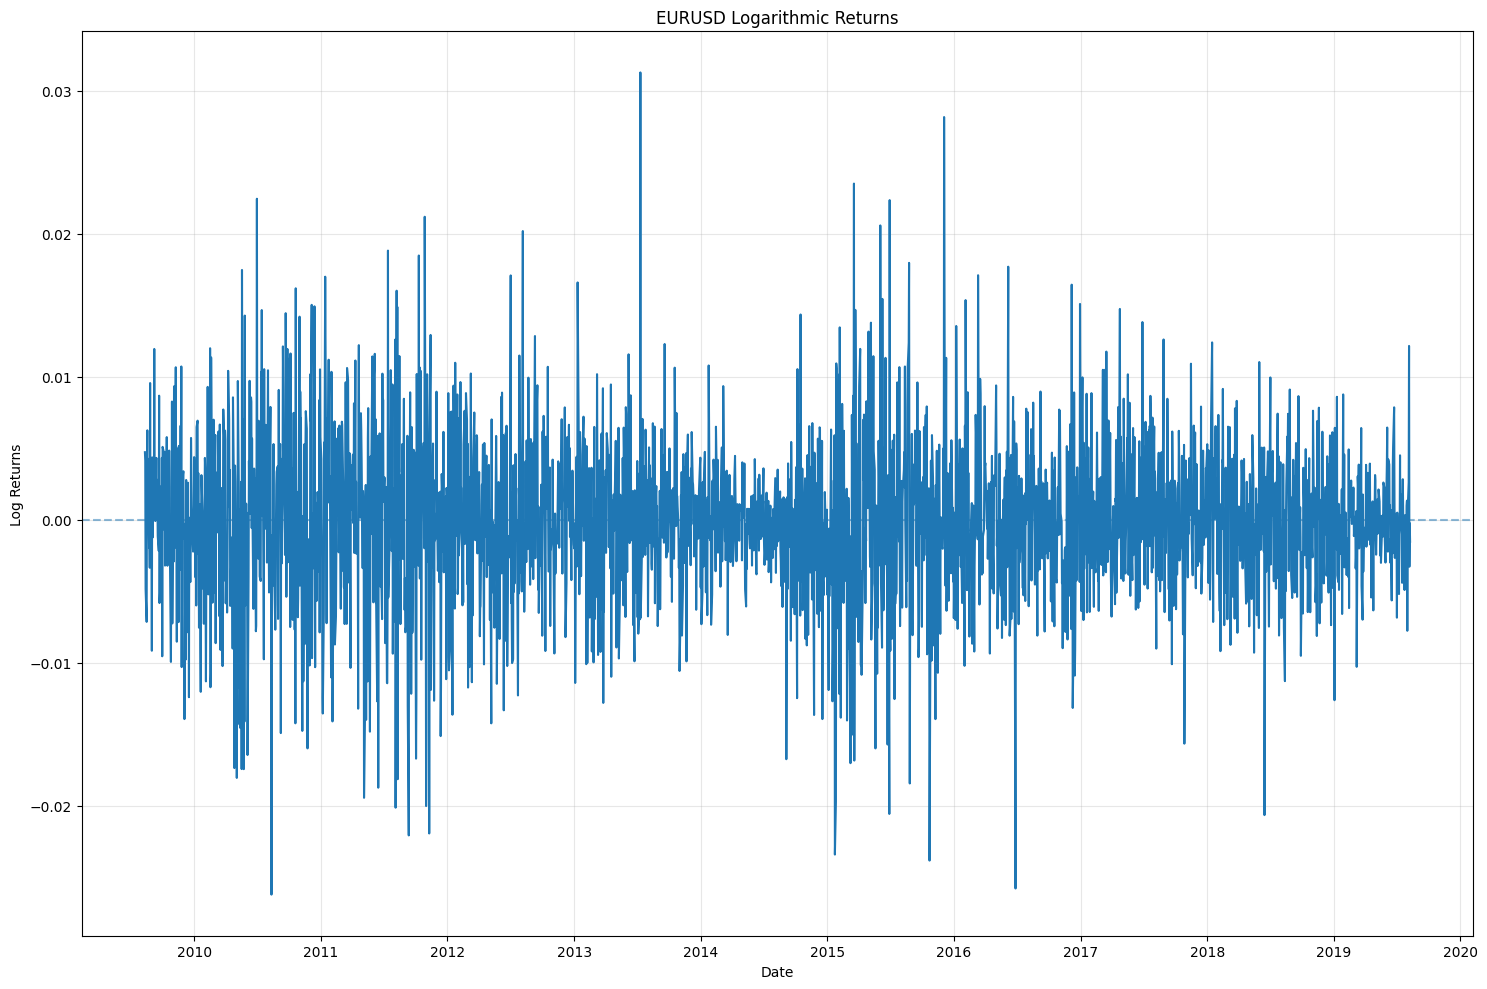

In [277]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(eurusd_clean.index, eurusd_clean['Log_Returns'])
ax.set_title('EURUSD Logarithmic Returns')
ax.set_ylabel('Log Returns')
ax.set_xlabel('Date')
ax.axhline(y=0, linestyle='--', alpha=0.5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## CV Splits

In [ ]:
# Time Series Cross-Validation Implementation
# Novel 3-fold cross-validation scheme with rolling windows

import matplotlib.dates as mdates
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# print("=== TIME SERIES CROSS-VALIDATION IMPLEMENTATION ===\n")

def create_sp500_cv_splits(data, start_date=None):
    if start_date is None:
        start_date = data.index.min()
    
    cv_splits = []
    window_start = start_date
    
    while True:
        # Define window boundaries
        train_start = window_start
        train_end = train_start + relativedelta(years=3) - timedelta(days=1)
        
        # Validation periods (8, 16, 24 months)
        val_start = train_end + timedelta(days=1)
        val1_end = val_start + relativedelta(months=8) - timedelta(days=1)  # 8 months
        val2_end = val_start + relativedelta(months=16) - timedelta(days=1) # 16 months  
        val3_end = val_start + relativedelta(months=24) - timedelta(days=1) # 24 months (2 years)
        
        # Test period (1 year)
        test_start = val3_end + timedelta(days=1)
        test_end = test_start + relativedelta(years=1) - timedelta(days=1)
        
        # Check if we have enough data
        # if test_end > data.index.max():
        if test_end.year > 2024:
            break
            
        # Create splits for this window
        train_data = data[(data.index >= train_start) & (data.index <= train_end)]
        
        # Three validation folds
        val1_data = data[(data.index >= val_start) & (data.index <= val1_end)]
        val2_data = data[(data.index >= val_start) & (data.index <= val2_end)]
        val3_data = data[(data.index >= val_start) & (data.index <= val3_end)]
        
        test_data = data[(data.index >= test_start) & (data.index <= test_end)]
        
        cv_splits.append({
            'window_id': len(cv_splits) + 1,
            'train': {
                'data': train_data,
                'start': train_start,
                'end': train_end,
                'size': len(train_data)
            },
            'validation': [
                {
                    'fold': 1,
                    'data': val1_data,
                    'start': val_start,
                    'end': val1_end,
                    'size': len(val1_data),
                    'months': 8
                },
                {
                    'fold': 2, 
                    'data': val2_data,
                    'start': val_start,
                    'end': val2_end,
                    'size': len(val2_data),
                    'months': 16
                },
                {
                    'fold': 3,
                    'data': val3_data,
                    'start': val_start,
                    'end': val3_end,
                    'size': len(val3_data),
                    'months': 24
                }
            ],
            'test': {
                'data': test_data,
                'start': test_start,
                'end': test_end,
                'size': len(test_data)
            }
        })
        
        # Move window forward by 1 year
        window_start += relativedelta(years=1)
    
    return cv_splits

def create_bitcoin_cv_splits(data, start_date=None):
    """
    Create Bitcoin cross-validation splits:
    - 2-year training + validation periods + 6-month test
    - Validation periods: 4, 8, 12 months
    - Window shifts forward by 6 months each iteration  
    - Testing period: 2018-01-01 to 2023-12-31
    """
    
    if start_date is None:
        # Start from a date that allows for proper window construction
        start_date = datetime(2015, 1, 1)
    
    cv_splits = []
    window_start = start_date
    
    # Define the testing period constraint
    test_period_start = datetime(2018, 1, 1)
    test_period_end = datetime(2023, 12, 31)
    
    while True:
        # Define window boundaries
        train_start = window_start
        train_end = train_start + relativedelta(years=2) - timedelta(days=1)
        
        # Validation periods (4, 8, 12 months)
        val_start = train_end + timedelta(days=1)
        val1_end = val_start + relativedelta(months=4) - timedelta(days=1)  # 4 months
        val2_end = val_start + relativedelta(months=8) - timedelta(days=1)  # 8 months
        val3_end = val_start + relativedelta(months=12) - timedelta(days=1) # 12 months
        
        # Test period (6 months)
        test_start = val3_end + timedelta(days=1)
        test_end = test_start + relativedelta(months=6) - timedelta(days=1)
        
        # Check constraints
        # if test_end > data.index.max() or test_end > test_period_end:
        #     break
        if test_end.year > 2023:
            break
        
        # Only include windows where test period is within 2018-2023
        if test_start < test_period_start:
            window_start += relativedelta(months=6)
            continue
            
        # Create splits for this window
        train_data = data[(data.index >= train_start) & (data.index <= train_end)]
        
        # Three validation folds
        val1_data = data[(data.index >= val_start) & (data.index <= val1_end)]
        val2_data = data[(data.index >= val_start) & (data.index <= val2_end)]
        val3_data = data[(data.index >= val_start) & (data.index <= val3_end)]
        
        test_data = data[(data.index >= test_start) & (data.index <= test_end)]
        
        cv_splits.append({
            'window_id': len(cv_splits) + 1,
            'train': {
                'data': train_data,
                'start': train_start,
                'end': train_end,
                'size': len(train_data)
            },
            'validation': [
                {
                    'fold': 1,
                    'data': val1_data,
                    'start': val_start,
                    'end': val1_end,
                    'size': len(val1_data),
                    'months': 4
                },
                {
                    'fold': 2,
                    'data': val2_data, 
                    'start': val_start,
                    'end': val2_end,
                    'size': len(val2_data),
                    'months': 8
                },
                {
                    'fold': 3,
                    'data': val3_data,
                    'start': val_start,
                    'end': val3_end,
                    'size': len(val3_data),
                    'months': 12
                }
            ],
            'test': {
                'data': test_data,
                'start': test_start,
                'end': test_end,
                'size': len(test_data)
            }
        })
        
        # Move window forward by 6 months
        window_start += relativedelta(months=6)
    
    return cv_splits

def create_eurusd_cv_splits(data, start_date=None):
    
    if start_date is None:
        start_date = data.index.min()
    
    cv_splits = []
    window_start = start_date
    
    while True:
        # Define window boundaries
        train_start = window_start
        train_end = train_start + relativedelta(years=2) - timedelta(days=1)
        
        # Validation periods (8, 16, 24 months)
        val_start = train_end + timedelta(days=1)
        val1_end = val_start + relativedelta(months=8) - timedelta(days=1)
        val2_end = val_start + relativedelta(months=16) - timedelta(days=1)
        val3_end = val_start + relativedelta(months=24) - timedelta(days=1)
        
        # Test period (6 months)
        test_start = val3_end + timedelta(days=1)
        test_end = test_start + relativedelta(months=6) - timedelta(days=1)
        
        # Check if we have enough data
        if test_end > data.index.max():
            break
            
        # Create splits for this window
        train_data = data[(data.index >= train_start) & (data.index <= train_end)]
        
        # Three validation folds
        val1_data = data[(data.index >= val_start) & (data.index <= val1_end)]
        val2_data = data[(data.index >= val_start) & (data.index <= val2_end)]
        val3_data = data[(data.index >= val_start) & (data.index <= val3_end)]
        
        test_data = data[(data.index >= test_start) & (data.index <= test_end)]
        
        cv_splits.append({
            'window_id': len(cv_splits) + 1,
            'train': {
                'data': train_data,
                'start': train_start,
                'end': train_end,
                'size': len(train_data)
            },
            'validation': [
                {
                    'fold': 1,
                    'data': val1_data,
                    'start': val_start,
                    'end': val1_end,
                    'size': len(val1_data),
                    'months': 8
                },
                {
                    'fold': 2,
                    'data': val2_data,
                    'start': val_start,
                    'end': val2_end,
                    'size': len(val2_data),
                    'months': 16
                },
                {
                    'fold': 3,
                    'data': val3_data,
                    'start': val_start,
                    'end': val3_end,
                    'size': len(val3_data),
                    'months': 24
                }
            ],
            'test': {
                'data': test_data,
                'start': test_start,
                'end': test_end,
                'size': len(test_data)
            }
        })
        
        # Move window forward by 1 year
        window_start += relativedelta(years=1)
    
    return cv_splits


In [279]:
# Create CV splits
sp500_cv_splits = create_sp500_cv_splits(sp500_clean)
bitcoin_cv_splits = create_bitcoin_cv_splits(bitcoin_clean)
eurusd_cv_splits = create_eurusd_cv_splits(eurusd_clean)


=== CROSS-VALIDATION SCHEME VISUALIZATION ===



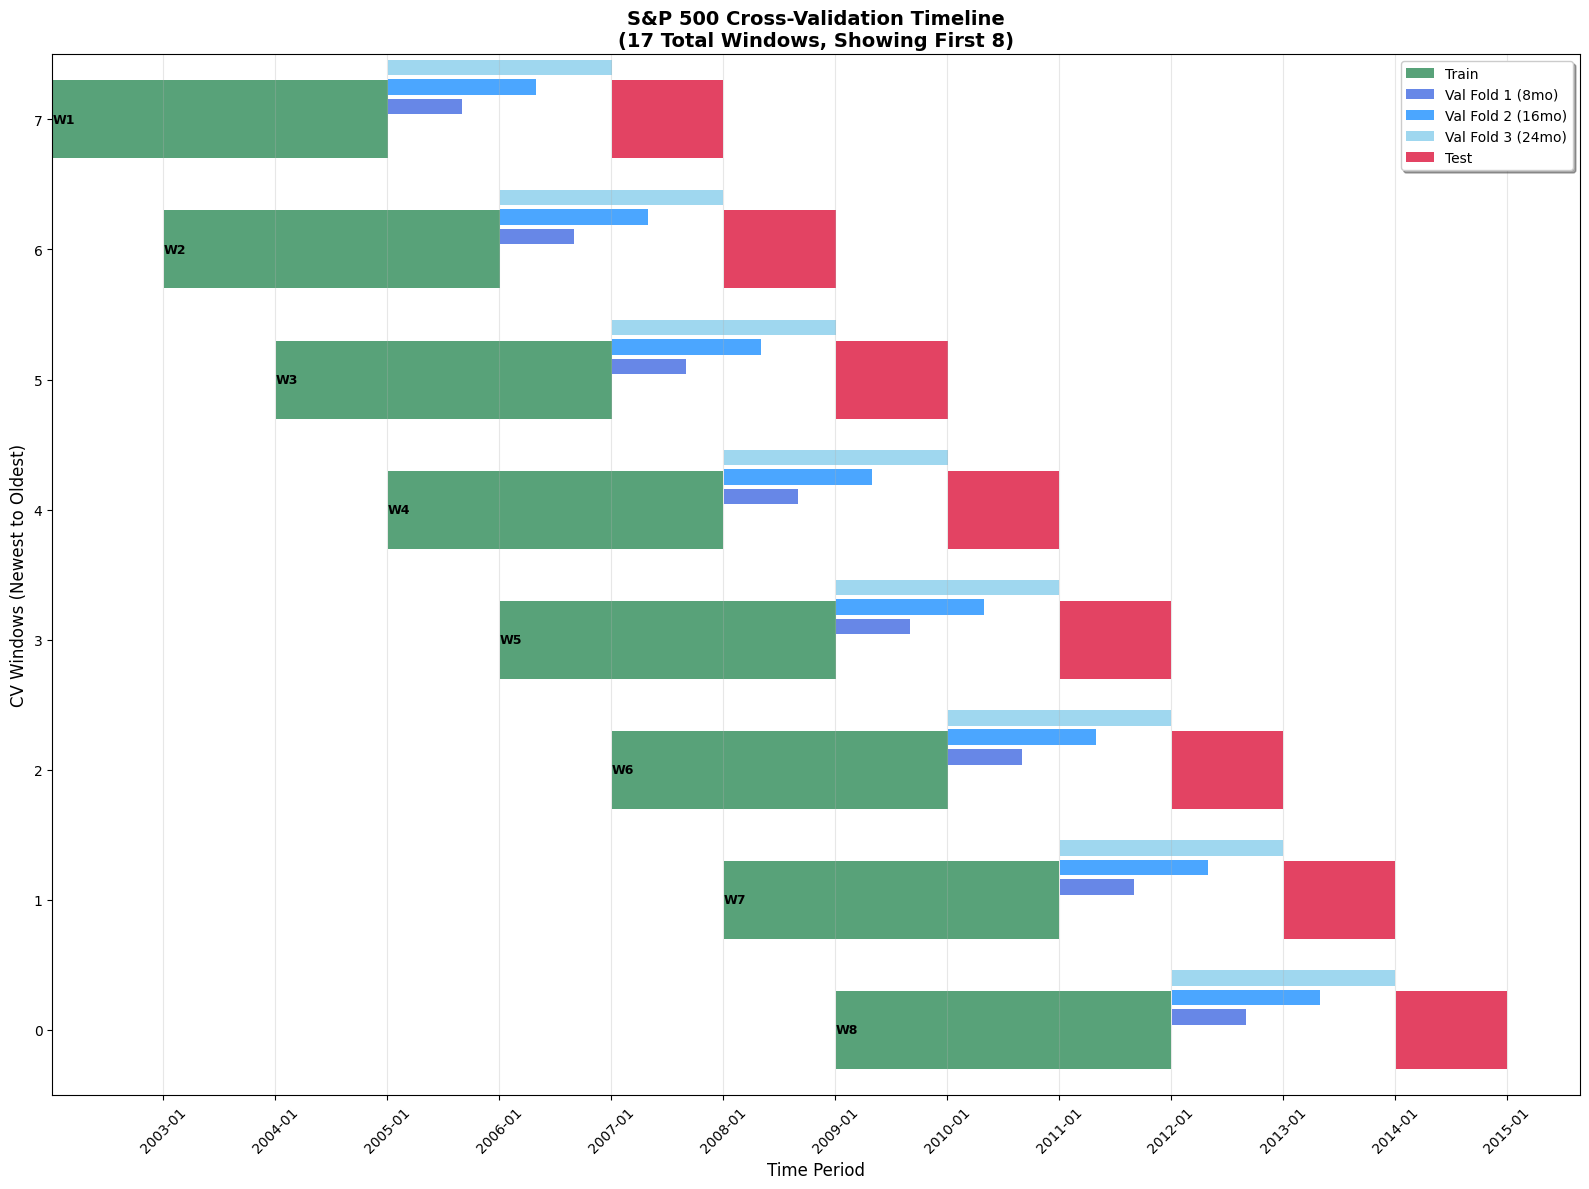

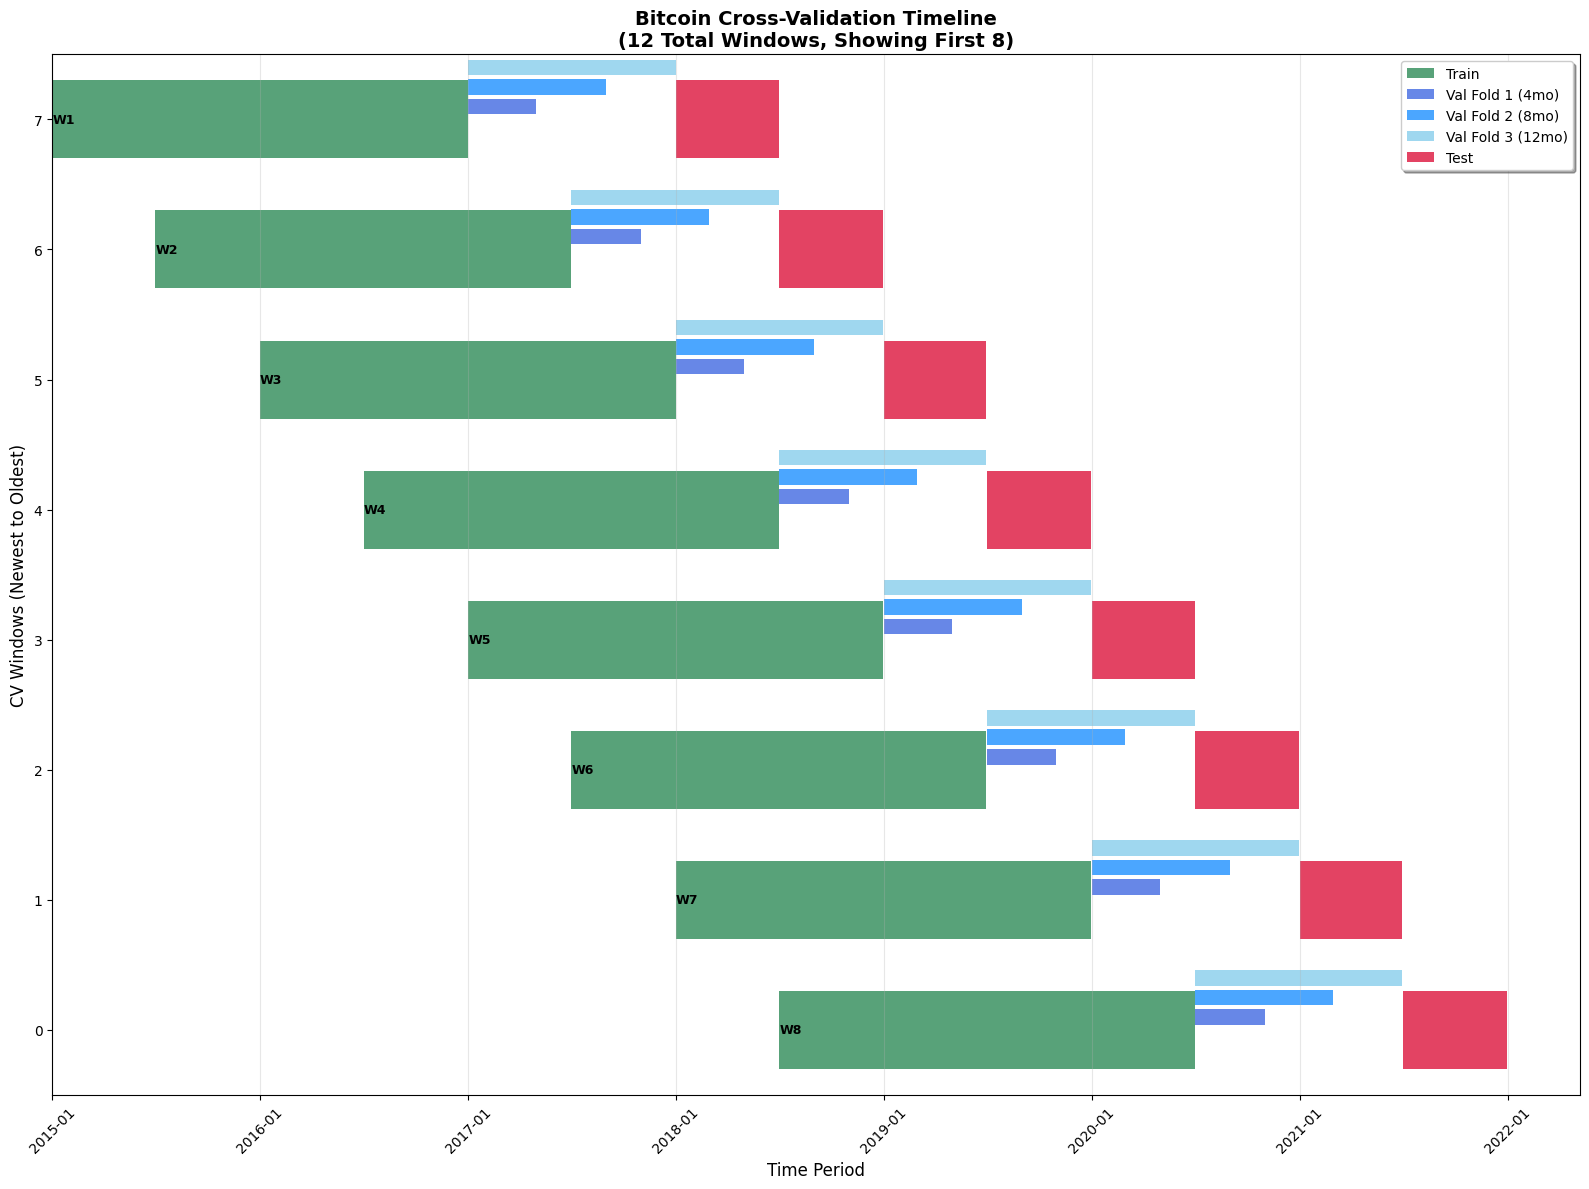

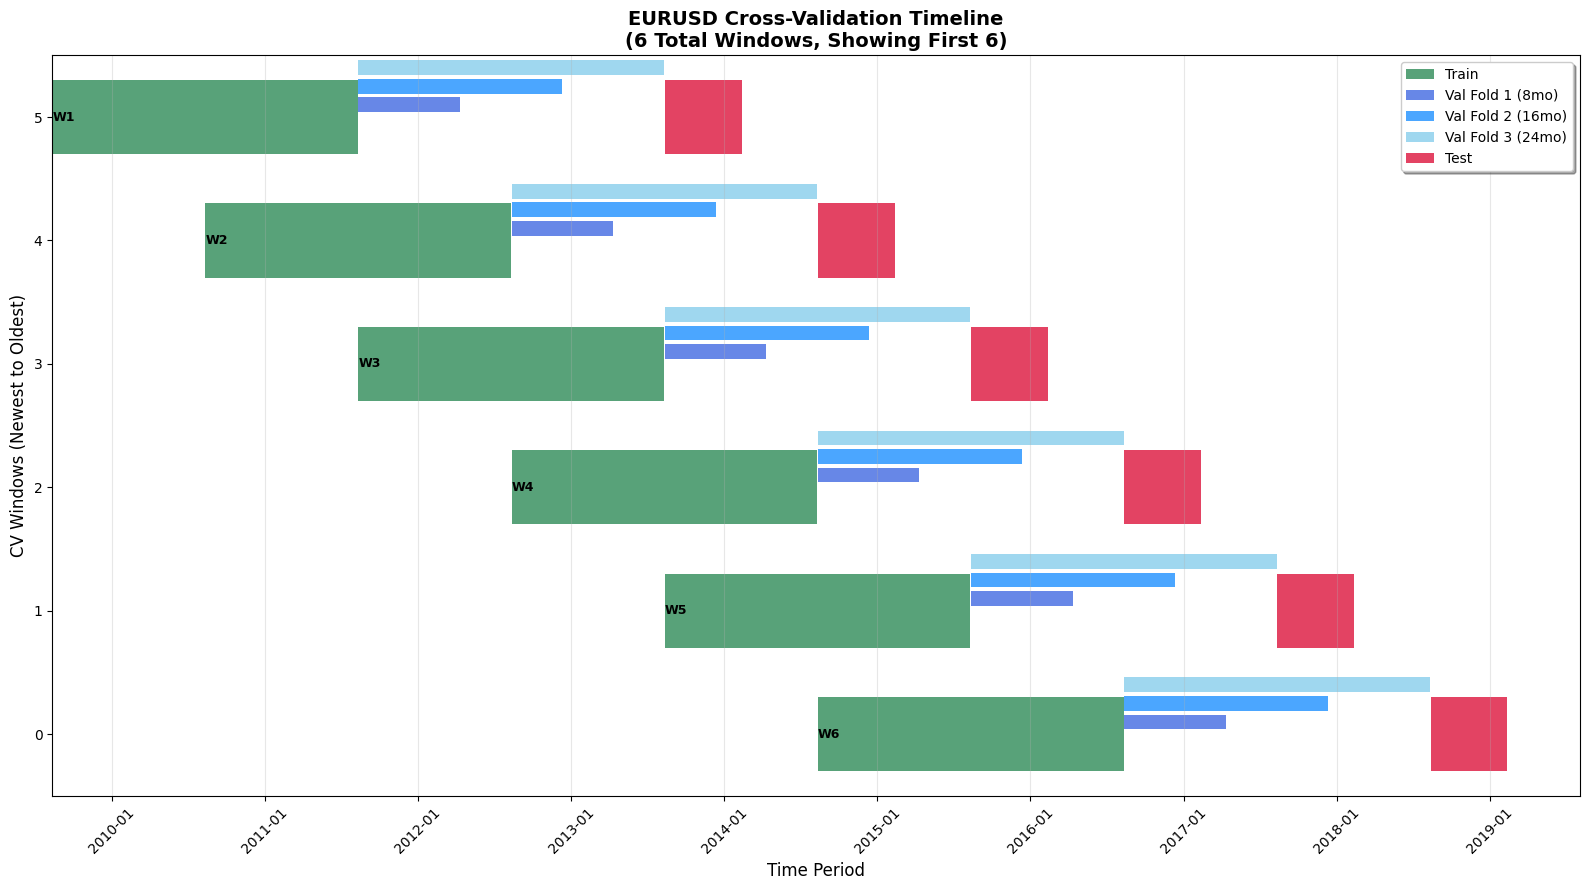

In [ ]:
# Visualize Cross-Validation Scheme

def plot_cv_timeline(cv_splits, asset_name, max_windows=8):
    
    fig, ax = plt.subplots(figsize=(16, max(6, len(cv_splits[:max_windows]) * 1.5)))
    
    # Colors for different split types
    colors = {
        'train': '#2E8B57',      # Sea Green
        'val_fold1': '#4169E1',  # Royal Blue
        'val_fold2': '#1E90FF',  # Dodger Blue  
        'val_fold3': '#87CEEB',  # Sky Blue
        'test': '#DC143C'        # Crimson
    }
    
    y_positions = []
    
    for i, split in enumerate(cv_splits[:max_windows]):
        y_pos = len(cv_splits[:max_windows]) - i - 1
        y_positions.append(y_pos)
        
        # Plot training period
        ax.barh(y_pos, (split['train']['end'] - split['train']['start']).days, 
                left=split['train']['start'], height=0.6, 
                color=colors['train'], alpha=0.8, label='Train' if i == 0 else "")
        
        # Plot validation periods
        val_colors = ['val_fold1', 'val_fold2', 'val_fold3']
        for j, val_fold in enumerate(split['validation']):
            ax.barh(y_pos + 0.1 + j*0.15, (val_fold['end'] - val_fold['start']).days,
                    left=val_fold['start'], height=0.12,
                    color=colors[val_colors[j]], alpha=0.8,
                    label=f'Val Fold {j+1} ({val_fold["months"]}mo)' if i == 0 else "")
        
        # Plot test period
        ax.barh(y_pos, (split['test']['end'] - split['test']['start']).days,
                left=split['test']['start'], height=0.6,
                color=colors['test'], alpha=0.8, label='Test' if i == 0 else "")
        
        # Add window labels
        ax.text(split['train']['start'], y_pos, f'W{split["window_id"]}',
                verticalalignment='center', fontsize=9, fontweight='bold')
    
    # Formatting
    ax.set_ylim(-0.5, len(cv_splits[:max_windows]) - 0.5)
    ax.set_ylabel('CV Windows (Newest to Oldest)', fontsize=12)
    ax.set_xlabel('Time Period', fontsize=12)
    ax.set_title(f'{asset_name} Cross-Validation Timeline\n({len(cv_splits)} Total Windows, Showing First {min(max_windows, len(cv_splits))})', 
                fontsize=14, fontweight='bold')
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)
    
    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=True, fancybox=True, shadow=True)
    
    # Add grid
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    return fig, ax


# Create visualizations
fig1, ax1 = plot_cv_timeline(sp500_cv_splits, 'S&P 500', max_windows=8)
fig1, ax2 = plot_cv_timeline(bitcoin_cv_splits, 'Bitcoin', max_windows=8)
fig1, ax3 = plot_cv_timeline(eurusd_cv_splits, 'EURUSD', max_windows=8)
plt.show()



In [ ]:
def get_cv_data(cv_splits, window_id, fold=None, return_type='data'):
    
    split = next((s for s in cv_splits if s['window_id'] == window_id), None)
    if split is None:
        raise ValueError(f"Window ID {window_id} not found")
    
    if return_type == 'train':
        return split['train']['data']
    elif return_type == 'test':
        return split['test']['data']
    elif return_type == 'validation':
        if fold is None:
            raise ValueError("Fold number must be specified for validation data")
        if fold not in [1, 2, 3]:
            raise ValueError("Fold must be 1, 2, or 3")
        return split['validation'][fold-1]['data']
    else:
        return split

## 2. GARCH Model Implementation

We'll use GARCH(1,1) which is the most common specification for financial volatility.

In [ ]:
def fit_garch_model(returns, p=1, q=1):
    # Multiply by 100 to scale the returns (common practice for GARCH estimation)
    returns_scaled = returns * 100
    
    # Specify GARCH model
    model = arch_model(returns_scaled, vol='Garch', p=p, q=q, rescale=False)
    
    # Fit model
    model_fit = model.fit(disp='off')
    
    return model_fit

def get_garch_volatility(model_fit, returns):
    """
    Extract conditional volatility from fitted GARCH model
    """
    # Get conditional volatility (already in percentage scale)
    conditional_vol = model_fit.conditional_volatility / 100
    
    return conditional_vol

In [ ]:
def run_garch_cross_validation(cv_splits, data_clean, asset_name, max_p=3, max_q=3, 
                               information_criterion='aic', verbose=True):

    ic_attr = information_criterion.lower()
    if ic_attr not in ['aic', 'bic', 'hqic']:
        raise ValueError("information_criterion must be one of: 'aic', 'bic', 'hqic'")

    print(f"\n=== {asset_name.upper()} GARCH CROSS-VALIDATION ===")
    print(f"Running {ic_attr.upper()}-based model selection across {len(cv_splits)} windows...")
    print(f"Parameter search space: p∈[1,{max_p}], q∈[1,{max_q}]")
    print("-" * 80)

    all_results = []
    model_selection_summary = []

    for window_idx, split in enumerate(cv_splits):
        window_id = split['window_id']

        if verbose:
            print(f"\n Processing Window {window_id}/{len(cv_splits)}...")
            print(f"   Train: {split['train']['start'].strftime('%Y-%m-%d')} "
                  f"to {split['train']['end'].strftime('%Y-%m-%d')} "
                  f"({split['train']['size']} obs)")
            print(f"   Test:  {split['test']['start'].strftime('%Y-%m-%d')} "
                  f"to {split['test']['end'].strftime('%Y-%m-%d')} "
                  f"({split['test']['size']} obs)")

        # Extract returns 
        train_data = split['train']['data']['Log_Returns'].copy()
        test_data = split['test']['data']['Log_Returns'].copy()

        #  Model Selection on Train via IC
        if verbose:
            print(f"    GARCH model selection using {ic_attr.upper()}...")

        best_ic = np.inf
        best_order = None
        best_model_fit = None

        for p in range(1, max_p + 1):
            for q in range(1, max_q + 1):
                try:
                    # Same scaling convention as your helper
                    returns_scaled = train_data * 100
                    model = arch_model(returns_scaled, vol='Garch', p=p, q=q, rescale=False)
                    model_fit = model.fit(disp='off')

                    ic_value = getattr(model_fit, ic_attr)

                    if np.isfinite(ic_value) and ic_value < best_ic:
                        best_ic = ic_value
                        best_order = (p, q)
                        best_model_fit = model_fit

                except Exception as e:
                    if verbose:
                        print(f"       GARCH({p},{q}) failed: {str(e)[:60]}...")
                    continue

        if best_model_fit is None:
            print(f"    Failed to find suitable GARCH model for Window {window_id}")
            continue

        if verbose:
            print(f"    Selected GARCH{best_order} with {ic_attr.upper()} = {best_ic:.4f}")

        #  Validation folds (rolling forecasts) 
        if verbose:
            print(f"    Validating GARCH{best_order} across 3 validation folds...")

        validation_scores = []

        for val_fold in split['validation']:
            fold_num = val_fold['fold']
            val_data = val_fold['data']['Log_Returns'].copy()

            # If the fold is empty, skip
            if len(val_data) == 0:
                if verbose:
                    print(f"       Validation fold {fold_num} is empty, skipping.")
                continue

            try:
                history = train_data.copy()
                val_forecast_vol = []

                # Rolling 1-step-ahead forecasts through the validation period
                for t_idx, (val_date, ret) in enumerate(val_data.items()):
                    model_fit_t = fit_garch_model(history, p=best_order[0], q=best_order[1])
                    cond_vol_t = get_garch_volatility(model_fit_t, history)
                    forecast_vol_t = cond_vol_t.iloc[-1]  # one-step-ahead for this date

                    val_forecast_vol.append(forecast_vol_t)

                    # Expand history to include this observed return
                    history = pd.concat([history, pd.Series([ret], index=[val_date])])

                val_forecast_vol = pd.Series(val_forecast_vol, index=val_data.index)
                realized_vol_val = np.abs(val_data)

                mask_val = val_forecast_vol.notna() & realized_vol_val.notna()
                if mask_val.sum() == 0:
                    if verbose:
                        print(f"       No valid forecasts in validation fold {fold_num}")
                    val_rmse = np.inf
                else:
                    val_rmse = np.sqrt(mean_squared_error(realized_vol_val[mask_val],
                                                          val_forecast_vol[mask_val]))

                validation_scores.append(val_rmse)

                if verbose:
                    print(f"      Fold {fold_num}: Validation RMSE={val_rmse:.6f}")

            except Exception as e:
                if verbose:
                    print(f"       Validation fold {fold_num} failed: {str(e)[:60]}...")
                validation_scores.append(np.inf)

        avg_validation_rmse = (np.mean(validation_scores)
                               if len(validation_scores) > 0
                               else np.inf)

        # Final test evaluation (rolling forecasts) 
        if verbose:
            print("    Final evaluation on test data...")

        try:
            # Keep best_model_fit for reference, but we'll do rolling forecasts like validation
            history = train_data.copy()
            test_forecast_vol = []

            for t_idx, (test_date, ret) in enumerate(test_data.items()):
                model_fit_t = fit_garch_model(history, p=best_order[0], q=best_order[1])
                cond_vol_t = get_garch_volatility(model_fit_t, history)
                forecast_vol_t = cond_vol_t.iloc[-1]

                test_forecast_vol.append(forecast_vol_t)
                history = pd.concat([history, pd.Series([ret], index=[test_date])])

            test_forecast_vol = pd.Series(test_forecast_vol, index=test_data.index)
            realized_vol_test = np.abs(test_data)

            mask_test = test_forecast_vol.notna() & realized_vol_test.notna()
            if mask_test.sum() == 0:
                print(f"    No valid test forecasts for Window {window_id}")
                continue

            test_rmse = np.sqrt(mean_squared_error(realized_vol_test[mask_test],
                                                   test_forecast_vol[mask_test]))
            test_mae = mean_absolute_error(realized_vol_test[mask_test],
                                           test_forecast_vol[mask_test])

            if verbose:
                print(f"   GARCH{best_order}: Test RMSE={test_rmse:.6f}, Test MAE={test_mae:.6f}")

            # In-sample train metrics from the selected model
            train_cond_vol = get_garch_volatility(best_model_fit, train_data)
            realized_vol_train = np.abs(train_data)

            train_rmse = np.sqrt(mean_squared_error(realized_vol_train, train_cond_vol))
            train_mae = mean_absolute_error(realized_vol_train, train_cond_vol)

            # Store detailed window result
            window_result = {
                'window_id': window_id,
                'asset': asset_name,
                'train_period': f"{split['train']['start'].strftime('%Y-%m-%d')} "
                                f"to {split['train']['end'].strftime('%Y-%m-%d')}",
                'test_period': f"{split['test']['start'].strftime('%Y-%m-%d')} "
                               f"to {split['test']['end'].strftime('%Y-%m-%d')}",
                'train_size': split['train']['size'],
                'test_size': split['test']['size'],
                'best_order': best_order,
                'best_ic_value': best_ic,
                'validation_scores': validation_scores,
                'avg_validation_rmse': avg_validation_rmse,
                'train_cond_vol': train_cond_vol,
                'test_forecast_vol': test_forecast_vol,
                'realized_vol_train': realized_vol_train,
                'realized_vol_test': realized_vol_test,
                'metrics': {
                    'train_rmse': train_rmse,
                    'train_mae': train_mae,
                    'test_rmse': test_rmse,
                    'test_mae': test_mae
                },
                'final_model': best_model_fit
            }

            all_results.append(window_result)

            # Summary row for quick reference (similar structure to ARIMA summary)
            model_selection_summary.append({
                'Window': window_id,
                'Best_Order': f"GARCH{best_order}",
                ic_attr.upper(): best_ic,
                'Validation_RMSE': avg_validation_rmse,
                'Train_RMSE': train_rmse,
                'Train_MAE': train_mae,
                'Test_RMSE': test_rmse,
                'Test_MAE': test_mae
            })

        except Exception as e:
            print(f"   Final evaluation failed for Window {window_id}: {str(e)[:80]}")
            continue

    # Build summary df & aggregate stats
    summary_df = pd.DataFrame(model_selection_summary)

    if len(summary_df) > 0:
        performance_summary = {
            'total_windows': len(cv_splits),
            'successful_windows': len(summary_df),
            'success_rate': len(summary_df) / len(cv_splits) * 100,
            'avg_test_rmse': summary_df['Test_RMSE'].mean(),
            'std_test_rmse': summary_df['Test_RMSE'].std(),
            'avg_test_mae': summary_df['Test_MAE'].mean(),
            'avg_train_rmse': summary_df['Train_RMSE'].mean(),
            'avg_train_mae': summary_df['Train_MAE'].mean(),
            'avg_validation_rmse': summary_df['Validation_RMSE'].mean(),
            'most_common_order': summary_df['Best_Order'].mode().iloc[0]
                                 if len(summary_df) > 0 else None
        }
    else:
        performance_summary = None

    print(f"\n{'='*80}")
    print(f"{asset_name.upper()} GARCH CROSS-VALIDATION COMPLETE")
    print(f"{'='*80}")

    if performance_summary:
        print(f"Successfully processed {performance_summary['successful_windows']}/"
              f"{performance_summary['total_windows']} windows")
        print(f"Average Test RMSE: {performance_summary['avg_test_rmse']:.6f} "
              f"± {performance_summary['std_test_rmse']:.6f}")
        print(f"Average Validation RMSE: {performance_summary['avg_validation_rmse']:.6f}")
        print(f" Most Common Model: {performance_summary['most_common_order']}")
    else:
        print(" No successful model fits achieved")

    return {
        'asset_name': asset_name,
        'all_results': all_results,
        'summary_df': summary_df,
        'performance_summary': performance_summary,
        'methodology': {
            'approach': f'{ic_attr.upper()}-based GARCH(p, q) selection',
            'information_criterion': information_criterion,
            'parameter_space': f'p∈[1,{max_p}], q∈[1,{max_q}]',
            'cross_validation': '3-fold temporal validation with rolling 1-step-ahead forecasts',
            'evaluation_metric': 'RMSE and MAE between predicted and realized volatility (|returns|)'
        }
    }


In [304]:
sp500_cv_splits = create_sp500_cv_splits(sp500_clean)
bitcoin_cv_splits = create_bitcoin_cv_splits(bitcoin_clean)
eurusd_cv_splits = create_eurusd_cv_splits(eurusd_clean)

garch_results_sp = run_garch_cross_validation(sp500_cv_splits, sp500_clean, 'S&P 500')



=== S&P 500 GARCH CROSS-VALIDATION ===
Running AIC-based model selection across 17 windows...
Parameter search space: p∈[1,3], q∈[1,3]
--------------------------------------------------------------------------------

🔄 Processing Window 1/17...
   Train: 2002-01-03 to 2005-01-02 (755 obs)
   Test:  2007-01-03 to 2008-01-02 (252 obs)
   🔍 GARCH model selection using AIC...
   ✅ Selected GARCH(2, 1) with AIC = 2194.9680
   📊 Validating GARCH(2, 1) across 3 validation folds...
     ✅ Fold 1: Validation RMSE=0.004071
     ✅ Fold 2: Validation RMSE=0.004233
     ✅ Fold 3: Validation RMSE=0.004381
   🎯 Final evaluation on test data...
   ✅ GARCH(2, 1): Test RMSE=0.007076, Test MAE=0.005663

🔄 Processing Window 2/17...
   Train: 2003-01-03 to 2006-01-02 (755 obs)
   Test:  2008-01-03 to 2009-01-02 (253 obs)
   🔍 GARCH model selection using AIC...
   ✅ Selected GARCH(1, 1) with AIC = 1745.5892
   📊 Validating GARCH(1, 1) across 3 validation folds...
     ✅ Fold 1: Validation RMSE=0.004805
   

In [305]:
garch_results_btc = run_garch_cross_validation(bitcoin_cv_splits, bitcoin_clean, 'Bitcoin')


=== BITCOIN GARCH CROSS-VALIDATION ===
Running AIC-based model selection across 12 windows...
Parameter search space: p∈[1,3], q∈[1,3]
--------------------------------------------------------------------------------

🔄 Processing Window 1/12...
   Train: 2015-01-01 to 2016-12-31 (730 obs)
   Test:  2018-01-01 to 2018-06-30 (181 obs)
   🔍 GARCH model selection using AIC...
   ✅ Selected GARCH(1, 3) with AIC = 3516.2915
   📊 Validating GARCH(1, 3) across 3 validation folds...
     ✅ Fold 1: Validation RMSE=0.033909
     ✅ Fold 2: Validation RMSE=0.033727
     ✅ Fold 3: Validation RMSE=0.038448
   🎯 Final evaluation on test data...
   ✅ GARCH(1, 3): Test RMSE=0.036637, Test MAE=0.029253

🔄 Processing Window 2/12...
   Train: 2015-07-01 to 2017-06-30 (731 obs)
   Test:  2018-07-01 to 2018-12-31 (184 obs)
   🔍 GARCH model selection using AIC...
   ✅ Selected GARCH(1, 2) with AIC = 3591.9836
   📊 Validating GARCH(1, 2) across 3 validation folds...
     ✅ Fold 1: Validation RMSE=0.042946
   

In [306]:
garch_results_eur = run_garch_cross_validation(eurusd_cv_splits, eurusd_clean, 'EURUSD')


=== EURUSD GARCH CROSS-VALIDATION ===
Running AIC-based model selection across 6 windows...
Parameter search space: p∈[1,3], q∈[1,3]
--------------------------------------------------------------------------------

🔄 Processing Window 1/6...
   Train: 2009-08-12 to 2011-08-11 (522 obs)
   Test:  2013-08-12 to 2014-02-11 (131 obs)
   🔍 GARCH model selection using AIC...
   ✅ Selected GARCH(1, 1) with AIC = 1110.2998
   📊 Validating GARCH(1, 1) across 3 validation folds...
     ✅ Fold 1: Validation RMSE=0.005067
     ✅ Fold 2: Validation RMSE=0.004574
     ✅ Fold 3: Validation RMSE=0.004421
   🎯 Final evaluation on test data...
   ✅ GARCH(1, 1): Test RMSE=0.003986, Test MAE=0.003506

🔄 Processing Window 2/6...
   Train: 2010-08-12 to 2012-08-11 (522 obs)
   Test:  2014-08-12 to 2015-02-11 (132 obs)
   🔍 GARCH model selection using AIC...
   ✅ Selected GARCH(1, 1) with AIC = 1146.9337
   📊 Validating GARCH(1, 1) across 3 validation folds...
     ✅ Fold 1: Validation RMSE=0.003590
     ✅ 

In [ ]:
# Comprehensive GARCH Results Analysis and Visualization

def create_garch_results_summary(sp500_results, bitcoin_results,eurusd_results):
    
    print("\n" + "="*100)
    print("COMPREHENSIVE GARCH ANALYSIS RESULTS")  
    print("="*100)
    
    # Combined summary statistics
    summary_stats = {
        'Asset': ['S&P 500', 'Bitcoin','EURUSD'],
        'Total_Windows': [
            sp500_results['performance_summary']['total_windows'] 
            if sp500_results['performance_summary'] else 0,
            bitcoin_results['performance_summary']['total_windows'] 
            if bitcoin_results['performance_summary'] else 0,
            eurusd_results['performance_summary']['total_windows'] 
            if eurusd_results['performance_summary'] else 0
        ],
        'Avg_Train_RMSE': [
            sp500_results['performance_summary']['avg_train_rmse'] 
            if sp500_results['performance_summary'] else np.nan,
            bitcoin_results['performance_summary']['avg_train_rmse'] 
            if bitcoin_results['performance_summary'] else np.nan,
            eurusd_results['performance_summary']['avg_train_rmse'] 
            if eurusd_results['performance_summary'] else np.nan
        ],
        'Avg_Validation_RMSE': [
            sp500_results['performance_summary']['avg_validation_rmse'] 
            if sp500_results['performance_summary'] else np.nan,
            bitcoin_results['performance_summary']['avg_validation_rmse'] 
            if bitcoin_results['performance_summary'] else np.nan,
            eurusd_results['performance_summary']['avg_validation_rmse'] 
            if eurusd_results['performance_summary'] else np.nan
        ],
        'Avg_Test_RMSE': [
            sp500_results['performance_summary']['avg_test_rmse'] 
            if sp500_results['performance_summary'] else np.nan,
            bitcoin_results['performance_summary']['avg_test_rmse'] 
            if bitcoin_results['performance_summary'] else np.nan,
            eurusd_results['performance_summary']['avg_test_rmse'] 
            if eurusd_results['performance_summary'] else np.nan
        ],
        'Avg_Test_MAE': [
            sp500_results['performance_summary']['avg_test_mae'] 
            if sp500_results['performance_summary'] else np.nan,
            bitcoin_results['performance_summary']['avg_test_mae'] 
            if bitcoin_results['performance_summary'] else np.nan,
            eurusd_results['performance_summary']['avg_test_mae'] 
            if eurusd_results['performance_summary'] else np.nan
        ],
        'Most_Common_Model': [
            sp500_results['performance_summary']['most_common_order'] 
            if sp500_results['performance_summary'] else 'N/A',
            bitcoin_results['performance_summary']['most_common_order'] 
            if bitcoin_results['performance_summary'] else 'N/A',
            eurusd_results['performance_summary']['most_common_order'] 
            if eurusd_results['performance_summary'] else 'N/A'
        ]
    }
    
    summary_df = pd.DataFrame(summary_stats)
    
    print("\n OVERALL PERFORMANCE SUMMARY (GARCH)")
    print("-" * 50)
    print(summary_df.to_string(index=False, float_format='%.6f'))
    
    # Detailed window-by-window results
    if len(sp500_results['summary_df']) > 0:
        print(f"\n S&P 500 GARCH DETAILED RESULTS ({len(sp500_results['summary_df'])} windows)")
        print("-" * 50)
        print(sp500_results['summary_df'].round(6).to_string(index=False))
    
    if len(bitcoin_results['summary_df']) > 0:
        print(f"\n BITCOIN GARCH DETAILED RESULTS ({len(bitcoin_results['summary_df'])} windows)")
        print("-" * 50)
        print(bitcoin_results['summary_df'].round(6).to_string(index=False))
    
    if len(eurusd_results['summary_df']) > 0:
        print(f"\n EURUSD GARCH DETAILED RESULTS ({len(eurusd_results['summary_df'])} windows)")
        print("-" * 50)
        print(eurusd_results['summary_df'].round(6).to_string(index=False))
    
    return summary_df


In [ ]:
def plot_garch_performance_analysis(sp500_results, bitcoin_results,eurusd_results):    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('GARCH Model Performance Analysis\nConditional Volatility Forecasting', 
                 fontsize=16, fontweight='bold')
    
    sp500_df = sp500_results['summary_df'] if len(sp500_results['summary_df']) > 0 else pd.DataFrame()
    bitcoin_df = bitcoin_results['summary_df'] if len(bitcoin_df := bitcoin_results['summary_df']) > 0 else pd.DataFrame()
    eurusd_df = eurusd_results['summary_df'] if len(eurusd_results['summary_df']) > 0 else pd.DataFrame()

    # Plot 1: Test RMSE Comparison
    ax1 = axes[0, 0]
    if len(sp500_df) > 0 and len(bitcoin_df) > 0 and len(eurusd_df) > 0:
        ax1.boxplot(
            [sp500_df['Test_RMSE'], bitcoin_df['Test_RMSE'],eurusd_df['Test_RMSE']], 
            labels=['S&P 500', 'Bitcoin','EURUSD'], 
            patch_artist=True
        )
        ax1.set_title('Test RMSE Distribution (GARCH)')
        ax1.set_ylabel('RMSE')
        ax1.grid(True, alpha=0.3)
    
    # Plot 2: Validation RMSE Comparison  
    ax2 = axes[0, 1]
    if len(sp500_df) > 0 and len(bitcoin_df) > 0 and len(eurusd_df) > 0:
        ax2.boxplot(
            [sp500_df['Validation_RMSE'], bitcoin_df['Validation_RMSE'],eurusd_df['Validation_RMSE']], 
            labels=['S&P 500', 'Bitcoin','EURUSD'], 
            patch_artist=True
        )
        ax2.set_title('Validation RMSE Distribution')
        ax2.set_ylabel('RMSE')
        ax2.grid(True, alpha=0.3)
    
    # Plot 3: RMSE over Windows (S&P 500)
    ax3 = axes[0,2]
    if len(sp500_df) > 0:
        ax3.plot(sp500_df['Window'], sp500_df['Test_RMSE'], 'o-', alpha=0.7, label='Test RMSE')
        ax3.plot(sp500_df['Window'], sp500_df['Validation_RMSE'], 's--', alpha=0.7, label='Validation RMSE')
        ax3.set_title('S&P 500 RMSE Evolution (GARCH)')
        ax3.set_xlabel('Window')
        ax3.set_ylabel('RMSE')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

    # Plot 4: RMSE over Windows (Bitcoin)
    ax4 = axes[1, 0]  
    if len(bitcoin_df) > 0:
        ax4.plot(bitcoin_df['Window'], bitcoin_df['Test_RMSE'], 'o-', alpha=0.7, label='Test RMSE')
        ax4.plot(bitcoin_df['Window'], bitcoin_df['Validation_RMSE'], 's--', alpha=0.7, label='Validation RMSE')
        ax4.set_title('Bitcoin RMSE Evolution (GARCH)')
        ax4.set_xlabel('Window')
        ax4.set_ylabel('RMSE')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

    # Plot 5: RMSE over Windows (EURUSD)
    ax5 = axes[1, 1]  
    if len(eurusd_df) > 0:
        ax5.plot(eurusd_df['Window'], eurusd_df['Test_RMSE'], 'o-', alpha=0.7, label='Test RMSE')
        ax5.plot(eurusd_df['Window'], eurusd_df['Validation_RMSE'], 's--', alpha=0.7, label='Validation RMSE')
        ax5.set_title('EURUSD RMSE Evolution (GARCH)')
        ax5.set_xlabel('Window')
        ax5.set_ylabel('RMSE')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
    
    # Plot 6: Train vs Test RMSE (per asset, bar)
    ax6 = axes[1, 2]
    if sp500_results['performance_summary'] and bitcoin_results['performance_summary'] and eurusd_results['performance_summary']:
        assets = ['S&P 500', 'Bitcoin','EURUSD']
        train_vals = [
            sp500_results['performance_summary']['avg_train_rmse'],
            bitcoin_results['performance_summary']['avg_train_rmse'],
            eurusd_results['performance_summary']['avg_train_rmse']
        ]
        test_vals = [
            sp500_results['performance_summary']['avg_test_rmse'],
            bitcoin_results['performance_summary']['avg_test_rmse'],
            eurusd_results['performance_summary']['avg_test_rmse']
        ]
        
        x = np.arange(len(assets))
        width = 0.35
        
        bars1 = ax6.bar(x - width/2, train_vals, width, label='Avg Train RMSE', alpha=0.7)
        bars2 = ax6.bar(x + width/2, test_vals, width, label='Avg Test RMSE', alpha=0.7)
        
        ax6.set_xticks(x)
        ax6.set_xticklabels(assets)
        ax6.set_title('Average Train vs Test RMSE (GARCH)')
        ax6.set_ylabel('RMSE')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        # Value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax6.text(
                    bar.get_x() + bar.get_width()/2., 
                    height, 
                    f'{height:.4f}', 
                    ha='center', va='bottom', fontsize=8
                )
    
    plt.tight_layout()
    return fig



COMPREHENSIVE GARCH ANALYSIS RESULTS

📊 OVERALL PERFORMANCE SUMMARY (GARCH)
--------------------------------------------------
  Asset  Total_Windows  Avg_Train_RMSE  Avg_Validation_RMSE  Avg_Test_RMSE  Avg_Test_MAE Most_Common_Model
S&P 500             17        0.007509             0.007745       0.008059      0.006284       GARCH(1, 1)
Bitcoin             12        0.031739             0.032845       0.030616      0.024479       GARCH(1, 2)
 EURUSD              6        0.004186             0.004002       0.003803      0.003130       GARCH(1, 1)

📈 S&P 500 GARCH DETAILED RESULTS (17 windows)
--------------------------------------------------
 Window  Best_Order         AIC  Validation_RMSE  Train_RMSE  Train_MAE  Test_RMSE  Test_MAE
      1 GARCH(2, 1) 2194.967951         0.004228    0.007584   0.006015   0.007076  0.005663
      2 GARCH(1, 1) 1745.589151         0.005128    0.005187   0.004267   0.016915  0.012405
      3 GARCH(2, 2) 1503.406879         0.008931    0.004366   0.00

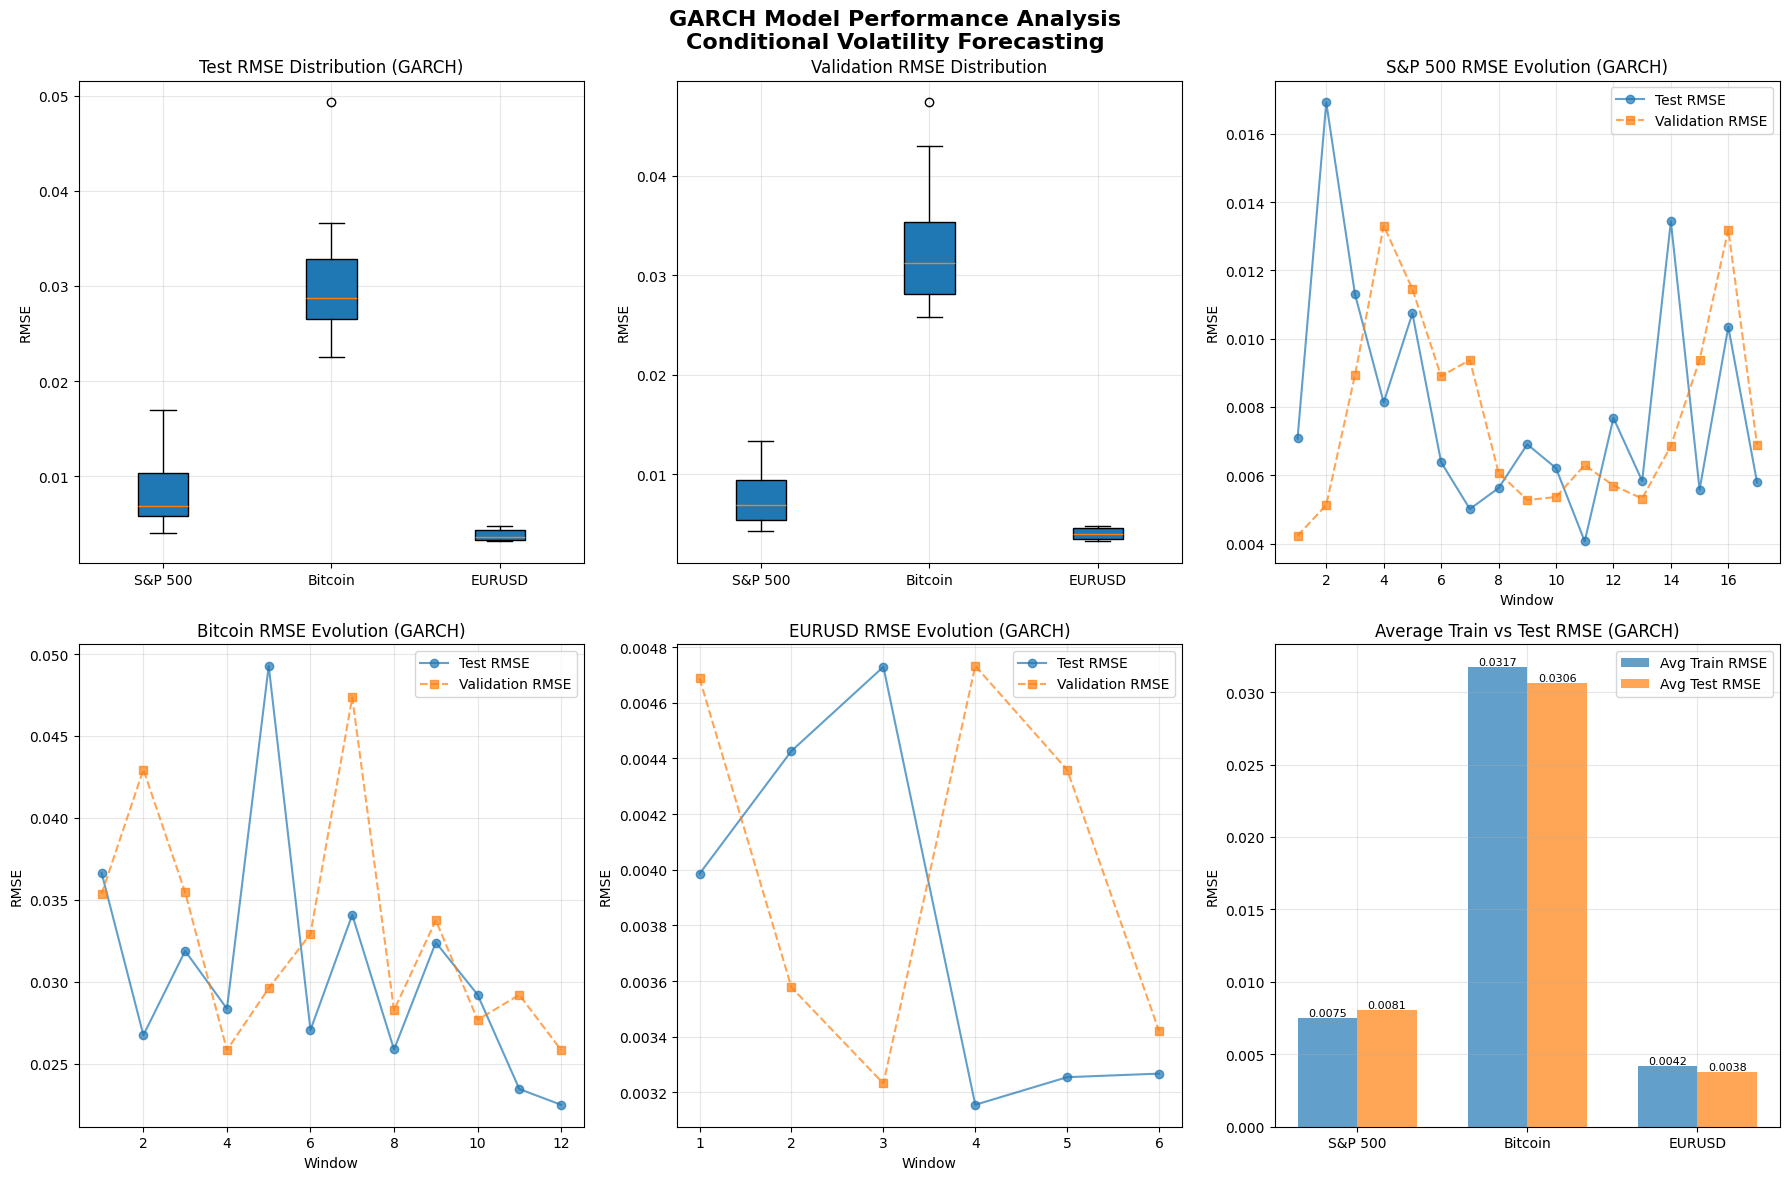


COMPREHENSIVE GARCH ANALYSIS RESULTS

📊 OVERALL PERFORMANCE SUMMARY (GARCH)
--------------------------------------------------
  Asset  Total_Windows  Avg_Train_RMSE  Avg_Validation_RMSE  Avg_Test_RMSE  Avg_Test_MAE Most_Common_Model
S&P 500             17        0.007509             0.007745       0.008059      0.006284       GARCH(1, 1)
Bitcoin             12        0.031739             0.032845       0.030616      0.024479       GARCH(1, 2)
 EURUSD              6        0.004186             0.004002       0.003803      0.003130       GARCH(1, 1)

📈 S&P 500 GARCH DETAILED RESULTS (17 windows)
--------------------------------------------------
 Window  Best_Order         AIC  Validation_RMSE  Train_RMSE  Train_MAE  Test_RMSE  Test_MAE
      1 GARCH(2, 1) 2194.967951         0.004228    0.007584   0.006015   0.007076  0.005663
      2 GARCH(1, 1) 1745.589151         0.005128    0.005187   0.004267   0.016915  0.012405
      3 GARCH(2, 2) 1503.406879         0.008931    0.004366   0.00

In [ ]:
# Assuming you already ran:
# garch_results_sp = run_garch_cross_validation(sp500_cv_splits, sp500_clean, 'S&P 500')
# garch_results_btc = run_garch_cross_validation(bitcoin_cv_splits, bitcoin_clean, 'Bitcoin')
# garch_results_eur = run_garch_cross_validation(eurusd_cv_splits, eurusd_clean, 'EURUSD')


garch_summary_df = create_garch_results_summary(garch_results_sp, garch_results_btc,garch_results_eur)
fig_garch = plot_garch_performance_analysis(garch_results_sp, garch_results_btc,garch_results_eur)
plt.show()

create_garch_results_summary(garch_results_sp, garch_results_btc,garch_results_eur)

print("✅ Successfully implemented IC-based GARCH methodology")
print(f"✅ Processed {len(sp500_cv_splits) + len(bitcoin_cv_splits) + len(eurusd_cv_splits)} total cross-validation windows (GARCH)")


In [ ]:
# Extract GARCH conditional volatility
sp500_clean['GARCH_Volatility'] = get_garch_volatility(sp500_garch, sp500_clean['Log_Returns'])
bitcoin_clean['GARCH_Volatility'] = get_garch_volatility(bitcoin_garch, bitcoin_clean['Log_Returns'])
eurusd_clean['GARCH_Volatility'] = get_garch_volatility(eurusd_garch, eurusd_clean['Log_Returns'])

print("\n GARCH Volatility Statistics ")
print(f"S&P 500 GARCH Volatility - Mean: {sp500_clean['GARCH_Volatility'].mean():.6f}, Std: {sp500_clean['GARCH_Volatility'].std():.6f}")
print(f"Bitcoin GARCH Volatility - Mean: {bitcoin_clean['GARCH_Volatility'].mean():.6f}, Std: {bitcoin_clean['GARCH_Volatility'].std():.6f}")
print(f"EURUSD GARCH Volatility - Mean: {eurusd_clean['GARCH_Volatility'].mean():.6f}, Std: {eurusd_clean['GARCH_Volatility'].std():.6f}")


=== GARCH Volatility Statistics ===
S&P 500 GARCH Volatility - Mean: 0.010440, Std: 0.006176
Bitcoin GARCH Volatility - Mean: 0.036201, Std: 0.014206
EURUSD GARCH Volatility - Mean: 0.005608, Std: 0.001440


## 3. LSTM Model Implementation

We'll create LSTM networks that use GARCH volatility predictions as input features to predict future volatility.

In [ ]:
def create_lstm_sequences(data, lookback=60):

    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

def build_lstm_model(lookback, units=50, dropout=0.2):

    model = Sequential()
    
    # First LSTM layer with return sequences
    model.add(LSTM(units=units, return_sequences=True, input_shape=(lookback, 1)))
    model.add(Dropout(dropout))
    
    # Second LSTM layer
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    
    # Third LSTM layer
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout))
    
    # Output layer
    model.add(Dense(units=1))
    
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [ ]:
def prepare_garch_lstm_data(data, train_split=0.8, lookback=60):

    # Use GARCH volatility as input feature
    garch_vol = data['GARCH_Volatility'].values.reshape(-1, 1)
    realized_vol = data['Realized_Volatility'].values.reshape(-1, 1)
    
    # Scale the data
    scaler_garch = MinMaxScaler(feature_range=(0, 1))
    scaler_realized = MinMaxScaler(feature_range=(0, 1))
    
    garch_vol_scaled = scaler_garch.fit_transform(garch_vol)
    realized_vol_scaled = scaler_realized.fit_transform(realized_vol)
    
    # Create sequences
    X, y = create_lstm_sequences(garch_vol_scaled, lookback)
    
    # Split into train and test
    train_size = int(len(X) * train_split)
    
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]
    
    # Reshape for LSTM [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Get corresponding realized volatility for comparison
    y_realized_train = realized_vol_scaled[lookback:lookback+train_size]
    y_realized_test = realized_vol_scaled[lookback+train_size:]
    
    return X_train, X_test, y_train, y_test, y_realized_train, y_realized_test, scaler_garch, scaler_realized

# LSTM CV Implementation

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

def create_lstm_sequences_multifeature(features, target, lookback=60):

    if target.ndim == 2:
        target = target.flatten()
        
    X, y = [], []
    for i in range(lookback, len(target)):
        X.append(features[i-lookback:i, :])   # (lookback, n_features)
        y.append(target[i])                   # scalar
    return np.array(X), np.array(y)


def build_lstm_model(lookback, n_features=1, units=50, dropout=0.2):

    model = Sequential()
    
    # First LSTM layer with return sequences
    model.add(LSTM(units=units, return_sequences=True, input_shape=(lookback, n_features)))
    model.add(Dropout(dropout))
    
    # Second LSTM layer
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    
    # Third LSTM layer
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout))
    
    # Output layer: predict realized volatility (scalar)
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
def prepare_garch_lstm_data_for_window(split, garch_window_result, lookback=60):

    # 1. Build full return series for this window (train + test)
    train_returns = split['train']['data']['Log_Returns']
    test_returns  = split['test']['data']['Log_Returns']
    
    returns_full = pd.concat([train_returns, test_returns])
    n_train = len(train_returns)
    n_test  = len(test_returns)
    T = n_train + n_test
    
    # Realized volatility (you can change to squared returns if you want)
    realized_vol_full = np.abs(returns_full.values)  # shape (T,)
    
    # 2. GARCH volatility for this window
    # From GARCH CV results:
    train_garch_vol = garch_window_result['train_cond_vol']          # index = train
    test_garch_vol  = garch_window_result['test_forecast_vol']       # index = test
    
    garch_vol_full = pd.concat([train_garch_vol, test_garch_vol])

    # Re-align to ensure correct order vs returns_full
    garch_vol_full = garch_vol_full.loc[returns_full.index].values   # shape (T,)
    
    # 3. Build feature matrix: [Realized_Vol, GARCH_Vol]
    features_full = np.column_stack([realized_vol_full, garch_vol_full])  # (T, 2)
    
    # 4. Scaling (keep similar to your previous approach)
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    
    X_scaled = scaler_X.fit_transform(features_full)
    y_scaled = scaler_y.fit_transform(realized_vol_full.reshape(-1, 1)).flatten()
    
    # 5. Create sequences for the full window 
    X_seq, y_seq = create_lstm_sequences_multifeature(X_scaled, y_scaled, lookback=lookback)
    # sequences indices map to target indices: target_index = lookback .. T-1
    N_seq = len(y_seq)
    
    # 6. Split sequences into train/test based on time index 

    n_train_seq = max(0, n_train - lookback)
    
    X_train = X_seq[:n_train_seq]
    y_train = y_seq[:n_train_seq]
    X_test  = X_seq[n_train_seq:]
    y_test  = y_seq[n_train_seq:]
    
    # 7. For evaluation in original scale, grab corresponding realized vol
    target_indices = np.arange(lookback, T)   # length N_seq
    
    train_target_idx = target_indices[:n_train_seq]
    test_target_idx  = target_indices[n_train_seq:]
    
    y_real_train_orig = realized_vol_full[train_target_idx]
    y_real_test_orig  = realized_vol_full[test_target_idx]
    
    return (X_train, X_test, y_train, y_test, 
            y_real_train_orig, y_real_test_orig,
            scaler_X, scaler_y)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def run_garch_lstm_cross_validation(cv_splits, garch_results, data_clean, asset_name,
                                    lookback=60, units=50, dropout=0.2,
                                    epochs=50, batch_size=32, verbose=1):
    print(f"\n=== {asset_name.upper()} GARCH-LSTM CROSS-VALIDATION ===")
    print(f"Lookback: {lookback} | Epochs: {epochs} | Batch size: {batch_size}")
    print("-" * 80)
    
    all_results = []
    summary_rows = []
    
    garch_window_results = {w['window_id']: w for w in garch_results['all_results']}
    
    for split in cv_splits:
        window_id = split['window_id']
        print(f"\n Processing Window {window_id}/{len(cv_splits)}...")
        
        if window_id not in garch_window_results:
            print(f"    No GARCH results found for Window {window_id}, skipping.")
            continue
        
        garch_w = garch_window_results[window_id]
        
        #Prepare data
        (X_train, X_test, y_train, y_test,
         y_real_train_orig, y_real_test_orig,
         scaler_X, scaler_y) = prepare_garch_lstm_data_for_window(
            split, garch_w, lookback=lookback
        )
        
        if X_train.shape[0] == 0 or X_test.shape[0] == 0:
            print(f"    Not enough sequence data for LSTM in Window {window_id}, skipping.")
            continue
        
        n_features = X_train.shape[2]
        print(f"   Train sequences: {X_train.shape[0]} | Test sequences: {X_test.shape[0]} | Features: {n_features}")
        
        #Build and train model 
        model = build_lstm_model(lookback=lookback, n_features=n_features,
                                 units=units, dropout=dropout)

        if verbose:
            print(model.summary())
        
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.1,
            verbose=verbose
        )
        
        #Predictions & metrics
        y_pred_test_scaled = model.predict(X_test).flatten()
        y_pred_test_orig = scaler_y.inverse_transform(
            y_pred_test_scaled.reshape(-1, 1)
        ).flatten()
        
        # RMSE / MAE on realized volatility in original scale
        test_rmse = np.sqrt(mean_squared_error(y_real_test_orig, y_pred_test_orig))
        test_mae = mean_absolute_error(y_real_test_orig, y_pred_test_orig)
        
        print(f"    Test RMSE (realized vol) = {test_rmse:.6f}, Test MAE = {test_mae:.6f}")
        
        # Store per-window result
        window_result = {
            'window_id': window_id,
            'asset': asset_name,
            'train_period': f"{split['train']['start'].strftime('%Y-%m-%d')} "
                            f"to {split['train']['end'].strftime('%Y-%m-%d')}",
            'test_period': f"{split['test']['start'].strftime('%Y-%m-%d')} "
                           f"to {split['test']['end'].strftime('%Y-%m-%d')}",
            'train_size_obs': split['train']['size'],
            'test_size_obs': split['test']['size'],
            'train_size_seq': X_train.shape[0],
            'test_size_seq': X_test.shape[0],
            'garch_order': garch_w['best_order'],
            'garch_ic_value': garch_w['best_ic_value'],
            'y_predictions': y_pred_test_orig,
            'y_actual': y_real_test_orig,
            'lookback': lookback,
            'lstm_units': units,
            'lstm_dropout': dropout,
            'metrics': {
                'test_rmse_realized_vol': test_rmse,
                'test_mae_realized_vol': test_mae
            },
            'model': model,
            'history': history.history,
            'scaler_X': scaler_X,
            'scaler_y': scaler_y
        }
        
        all_results.append(window_result)
        
        summary_rows.append({
            'Window': window_id,
            'GARCH_Order': f"GARCH{garch_w['best_order']}",
            'Lookback': lookback,
            'Train_Seq': X_train.shape[0],
            'Test_Seq': X_test.shape[0],
            'Test_RMSE_RealVol': test_rmse,
            'Test_MAE_RealVol': test_mae
        })
    
    summary_df = pd.DataFrame(summary_rows).sort_values('Window')
    
    if len(summary_df) > 0:
        performance_summary = {
            'total_windows': len(cv_splits),
            'successful_windows': len(summary_df),
            'success_rate': len(summary_df) / len(cv_splits) * 100,
            'avg_test_rmse_realvol': summary_df['Test_RMSE_RealVol'].mean(),
            'std_test_rmse_realvol': summary_df['Test_RMSE_RealVol'].std(),
            'avg_test_mae_realvol': summary_df['Test_MAE_RealVol'].mean(),
            'std_test_mae_realvol': summary_df['Test_MAE_RealVol'].std()
        }
    else:
        performance_summary = None
    
    print("\n" + "="*80)
    print(f"{asset_name.upper()} GARCH-LSTM CROSS-VALIDATION COMPLETE")
    print("="*80)
    if performance_summary:
        print(f" Successfully processed {performance_summary['successful_windows']}/"
              f"{performance_summary['total_windows']} windows")
        print(f" Avg Test RMSE (realized vol): "
              f"{performance_summary['avg_test_rmse_realvol']:.6f} "
              f"± {performance_summary['std_test_rmse_realvol']:.6f}")
        print(f" Avg Test MAE (realized vol): "
              f"{performance_summary['avg_test_mae_realvol']:.6f} "
              f"± {performance_summary['std_test_mae_realvol']:.6f}")
    else:
        print(" No successful GARCH-LSTM windows.")
    
    return {
        'asset_name': asset_name,
        'all_results': all_results,
        'summary_df': summary_df,
        'performance_summary': performance_summary,
        'methodology': {
            'approach': 'GARCH-LSTM hybrid with CV windows',
            'features': '[Realized Volatility, GARCH Conditional Volatility]',
            'target': 'Realized Volatility',
            'lookback': lookback,
            'lstm_architecture': '3-layer LSTM + Dense(1)',
            'garch_results_source': 'run_garch_cross_validation outputs'
        }
    }


## 4. Train GARCH-LSTM Hybrid Models

In [ ]:
lookback = 20

garch_lstm_sp = run_garch_lstm_cross_validation(
    sp500_cv_splits,
    garch_results_sp,
    sp500_clean,
    asset_name='S&P 500',
    lookback=lookback,
    units=50,
    dropout=0.2,
    epochs=50,
    batch_size=32,
    verbose=0
)


=== S&P 500 GARCH-LSTM CROSS-VALIDATION ===
Lookback: 20 | Epochs: 50 | Batch size: 32
--------------------------------------------------------------------------------

🔄 Processing Window 1/17...
   Train sequences: 735 | Test sequences: 252 | Features: 2
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
   ✅ Test RMSE (realized vol) = 0.006806, Test MAE = 0.005248

🔄 Processing Window 2/17...
   Train sequences: 735 | Test sequences: 253 | Features: 2
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step
   ✅ Test RMSE (realized vol) = 0.023984, Test MAE = 0.015972

🔄 Processing Window 3/17...
   Train sequences: 734 | Test sequences: 251 | Features: 2
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step
   ✅ Test RMSE (realized vol) = 0.012365, Test MAE = 0.008233

🔄 Processing Window 4/17...
   Train sequences: 735 | Test sequences: 252 | Features: 2
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
   ✅ Test RMSE (realized vol) = 0.007714, Test MAE = 0.005748

🔄 Processing Window 5/17...
   Train sequences: 736 | Test sequences: 252

In [ ]:
lookback = 30

garch_lstm_btc = run_garch_lstm_cross_validation(
    bitcoin_cv_splits,
    garch_results_btc,
    bitcoin_clean,
    asset_name='Bitcoin',
    lookback=lookback,
    units=50,
    dropout=0.2,
    epochs=50,
    batch_size=32,
    verbose=0
)



=== BITCOIN GARCH-LSTM CROSS-VALIDATION ===
Lookback: 30 | Epochs: 50 | Batch size: 32
--------------------------------------------------------------------------------

🔄 Processing Window 1/12...
   Train sequences: 700 | Test sequences: 181 | Features: 2


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
   ✅ Test RMSE (realized vol) = 0.035375, Test MAE = 0.024424

🔄 Processing Window 2/12...
   Train sequences: 701 | Test sequences: 184 | Features: 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
   ✅ Test RMSE (realized vol) = 0.024629, Test MAE = 0.016551

🔄 Processing Window 3/12...
   Train sequences: 701 | Test sequences: 181 | Features: 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
   ✅ Test RMSE (realized vol) = 0.027032, Test MAE = 0.018500

🔄 Processing Window 4/12...
   Train sequences: 700 | Test sequences: 184 | Features: 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
   ✅ Test RMSE (realized vol) = 0.025177, Test MAE = 0.017865

🔄 Processing Window 5/12...
   Train sequences: 700 | Test sequences: 182 | Features: 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
   ✅ Test RMSE (realized vol) = 0.041350, Test MAE = 0.022502

🔄 Processing Window 6/12...
   Train sequences: 700 | Test sequences: 184 | Features: 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
   ✅ Test RMSE (r

In [ ]:
garch_lstm_eur = run_garch_lstm_cross_validation(
    eurusd_cv_splits,
    garch_results_eur,
    eurusd_clean,
    asset_name='EURUSD',
    lookback=lookback,
    units=50,
    dropout=0.2,
    epochs=50,
    batch_size=32,
    verbose=0
)


=== EURUSD GARCH-LSTM CROSS-VALIDATION ===
Lookback: 30 | Epochs: 50 | Batch size: 32
--------------------------------------------------------------------------------

🔄 Processing Window 1/6...
   Train sequences: 492 | Test sequences: 131 | Features: 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
   ✅ Test RMSE (realized vol) = 0.003270, Test MAE = 0.002850

🔄 Processing Window 2/6...
   Train sequences: 492 | Test sequences: 132 | Features: 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
   ✅ Test RMSE (realized vol) = 0.004283, Test MAE = 0.003103

🔄 Processing Window 3/6...
   Train sequences: 490 | Test sequences: 132 | Features: 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
   ✅ Test RMSE (realized vol) = 0.004620, Test MAE = 0.003297

🔄 Processing Window 4/6...
   Train sequences: 489 | Test sequences: 131 | Features: 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step
   ✅ Test RMSE (realized vol) = 0.003157, Test MAE = 0.002319

🔄 Processing Window 5/6...
   Train sequences: 491 | Test sequences: 129 | F

## 5. Model Predictions and Performance Metrics

In [ ]:
def compare_garch_vs_garch_lstm(garch_results, garch_lstm_results, asset_label="S&P 500"):
    """
    Compare baseline GARCH vs GARCH-LSTM hybrid using cross-validation summaries.
    
    Prints:
      - Average Test RMSE / MAE for both models
      - Percentage improvement of hybrid over GARCH
    """
    garch_ps = garch_results.get('performance_summary', None)
    hybrid_ps = garch_lstm_results.get('performance_summary', None)
    
    if garch_ps is None or hybrid_ps is None:
        print(f"\n Missing performance summary for {asset_label}.")
        return
    
    # Baseline GARCH test metrics (averaged across windows)
    rmse_garch_test = garch_ps['avg_test_rmse']
    mae_garch_test  = garch_ps['avg_test_mae']
    
    # Hybrid GARCH-LSTM test metrics (averaged across windows)
    rmse_hybrid_test = hybrid_ps['avg_test_rmse_realvol']
    mae_hybrid_test  = hybrid_ps['avg_test_mae_realvol']
    
    # (Optional) you could also define proxy "train" metrics from summaries if needed,
    # but we focus on test performance like in the paper.
    
    print(f"\n=== {asset_label} Performance Metrics (Cross-Validation Averages) ===")
    
    print("\nGARCH-LSTM Hybrid Model (Averaged over windows):")
    print(f"Test Set - RMSE: {rmse_hybrid_test:.8f}, MAE: {mae_hybrid_test:.8f}")
    
    print("\nGARCH Model (Baseline, Averaged over windows):")
    print(f"Test Set - RMSE: {rmse_garch_test:.8f}, MAE: {mae_garch_test:.8f}")
    
    # Improvement (%)
    rmse_impr = (rmse_garch_test - rmse_hybrid_test) / rmse_garch_test * 100 if rmse_garch_test != 0 else 0.0
    mae_impr  = (mae_garch_test - mae_hybrid_test) / mae_garch_test * 100 if mae_garch_test != 0 else 0.0
    
    print("\nImprovement over GARCH (Test, Averages):")
    print(f"Test RMSE Improvement: {rmse_impr:.2f}%")
    print(f"Test MAE Improvement: {mae_impr:.2f}%")


In [342]:
compare_garch_vs_garch_lstm(garch_results_sp,  garch_lstm_sp,  asset_label="S&P 500")
compare_garch_vs_garch_lstm(garch_results_btc, garch_lstm_btc, asset_label="Bitcoin")
compare_garch_vs_garch_lstm(garch_results_eur, garch_lstm_eur, asset_label="EURUSD")



=== S&P 500 Performance Metrics (Cross-Validation Averages) ===

GARCH-LSTM Hybrid Model (Averaged over windows):
Test Set - RMSE: 0.00812393, MAE: 0.00582598

GARCH Model (Baseline, Averaged over windows):
Test Set - RMSE: 0.00805923, MAE: 0.00628437

Improvement over GARCH (Test, Averages):
Test RMSE Improvement: -0.80%
Test MAE Improvement: 7.29%

=== Bitcoin Performance Metrics (Cross-Validation Averages) ===

GARCH-LSTM Hybrid Model (Averaged over windows):
Test Set - RMSE: 0.02636106, MAE: 0.01823578

GARCH Model (Baseline, Averaged over windows):
Test Set - RMSE: 0.03061633, MAE: 0.02447866

Improvement over GARCH (Test, Averages):
Test RMSE Improvement: 13.90%
Test MAE Improvement: 25.50%

=== EURUSD Performance Metrics (Cross-Validation Averages) ===

GARCH-LSTM Hybrid Model (Averaged over windows):
Test Set - RMSE: 0.00352781, MAE: 0.00272588

GARCH Model (Baseline, Averaged over windows):
Test Set - RMSE: 0.00380335, MAE: 0.00312980

Improvement over GARCH (Test, Averages):

## 6. Visualizations

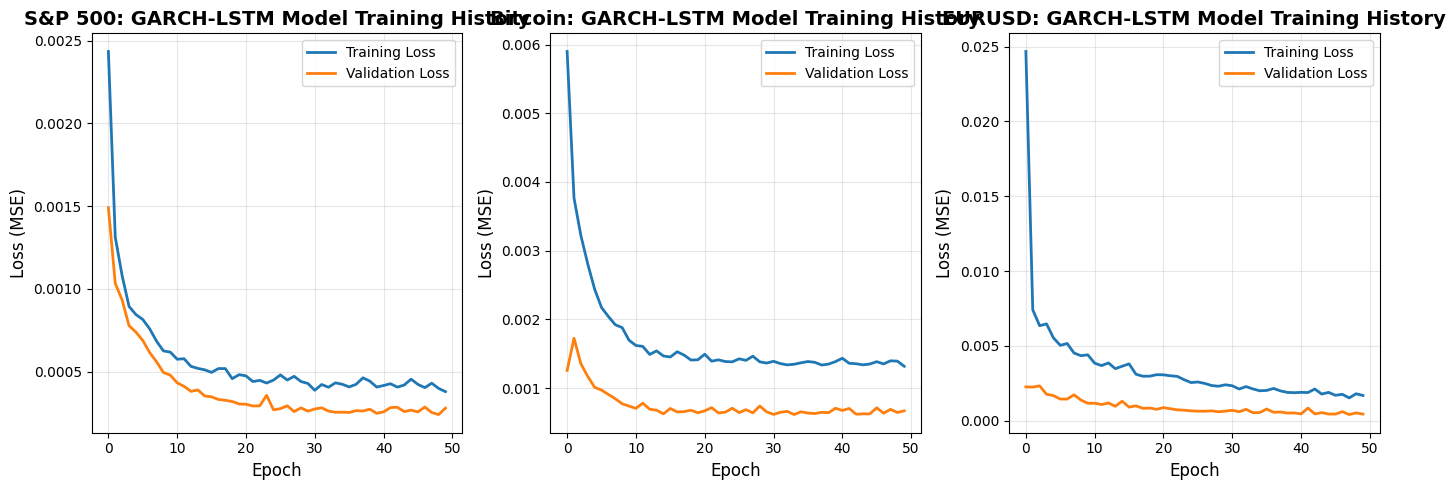

In [343]:
# Plot training history for S&P 500
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(history_sp.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_sp.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('S&P 500: GARCH-LSTM Model Training History', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history_btc.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_btc.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Bitcoin: GARCH-LSTM Model Training History', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history_eurusd.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_eurusd.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('EURUSD: GARCH-LSTM Model Training History', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)


plt.tight_layout()
# plt.savefig('garch_lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# print("Training history plot saved as 'garch_lstm_training_history.png'")

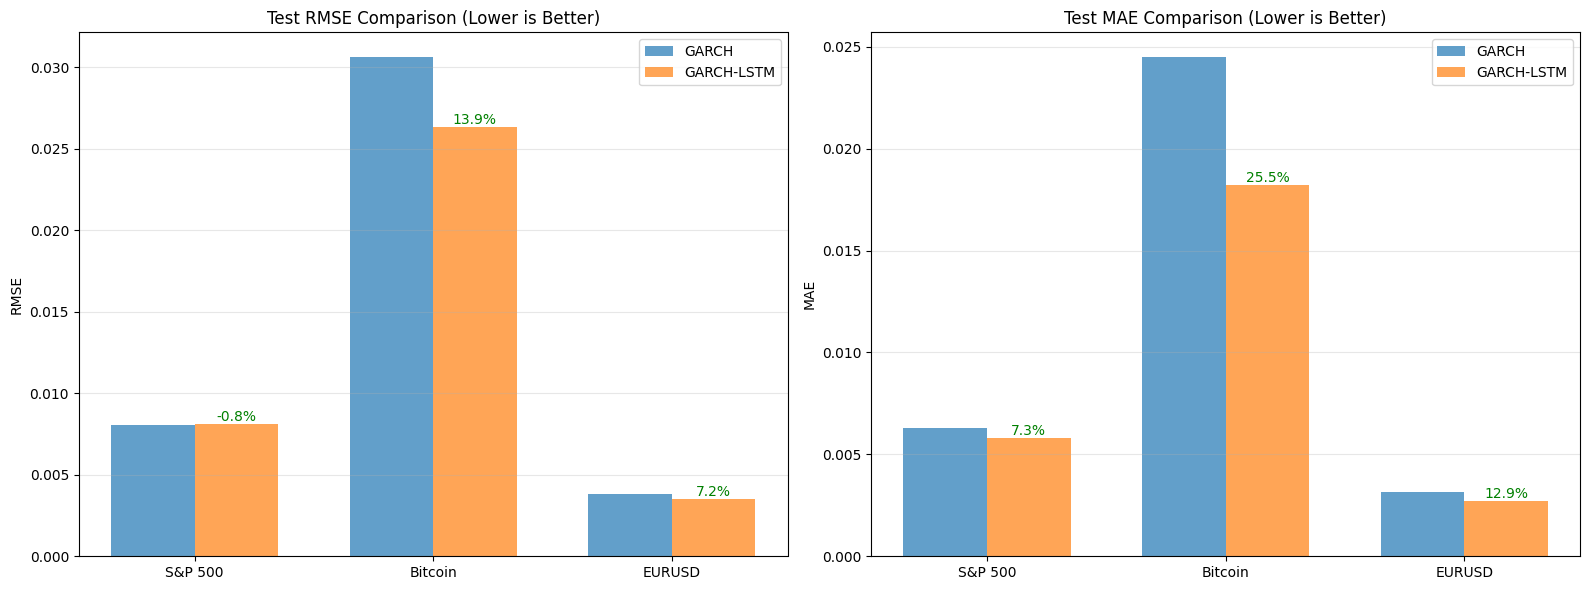

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_garch_vs_garch_lstm_bar(
    garch_results_sp, garch_results_btc, garch_results_eur,
    garch_lstm_sp, garch_lstm_btc, garch_lstm_eur
):
    """
    Creates bar plots comparing GARCH vs GARCH-LSTM Test RMSE and MAE
    across S&P 500, Bitcoin, and EURUSD.
    """
    # Extract metrics

    datasets = ["S&P 500", "Bitcoin", "EURUSD"]

    garch_rmse = [
        garch_results_sp['performance_summary']['avg_test_rmse'],
        garch_results_btc['performance_summary']['avg_test_rmse'],
        garch_results_eur['performance_summary']['avg_test_rmse']
    ]

    garch_mae = [
        garch_results_sp['performance_summary']['avg_test_mae'],
        garch_results_btc['performance_summary']['avg_test_mae'],
        garch_results_eur['performance_summary']['avg_test_mae']
    ]

    hybrid_rmse = [
        garch_lstm_sp['performance_summary']['avg_test_rmse_realvol'],
        garch_lstm_btc['performance_summary']['avg_test_rmse_realvol'],
        garch_lstm_eur['performance_summary']['avg_test_rmse_realvol']
    ]

    hybrid_mae = [
        garch_lstm_sp['performance_summary']['avg_test_mae_realvol'],
        garch_lstm_btc['performance_summary']['avg_test_mae_realvol'],
        garch_lstm_eur['performance_summary']['avg_test_mae_realvol']
    ]

    # Percentage improvement
    rmse_improvement = [(g - h) / g * 100 for g, h in zip(garch_rmse, hybrid_rmse)]
    mae_improvement  = [(g - h) / g * 100 for g, h in zip(garch_mae, hybrid_mae)]

    x = np.arange(len(datasets))
    width = 0.35  # bar width

    # Plot Test RMSE
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    ax0 = ax[0]
    bars1 = ax0.bar(x - width/2, garch_rmse, width, label='GARCH', alpha=0.7)
    bars2 = ax0.bar(x + width/2, hybrid_rmse, width, label='GARCH-LSTM', alpha=0.7)

    ax0.set_title("Test RMSE Comparison (Lower is Better)")
    ax0.set_xticks(x)
    ax0.set_xticklabels(datasets)
    ax0.set_ylabel("RMSE")
    ax0.legend()
    ax0.grid(axis='y', alpha=0.3)

    # Annotate improvements
    for i in range(len(x)):
        ax0.text(x[i] + width/2, hybrid_rmse[i], f"{rmse_improvement[i]:.1f}%", 
                 ha='center', va='bottom', fontsize=10, color='green')

    # Plot Test MAE
    ax1 = ax[1]
    bars3 = ax1.bar(x - width/2, garch_mae, width, label='GARCH', alpha=0.7)
    bars4 = ax1.bar(x + width/2, hybrid_mae, width, label='GARCH-LSTM', alpha=0.7)

    ax1.set_title("Test MAE Comparison (Lower is Better)")
    ax1.set_xticks(x)
    ax1.set_xticklabels(datasets)
    ax1.set_ylabel("MAE")
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # Annotate improvements
    for i in range(len(x)):
        ax1.text(x[i] + width/2, hybrid_mae[i], f"{mae_improvement[i]:.1f}%", 
                 ha='center', va='bottom', fontsize=10, color='green')

    plt.tight_layout()
    plt.show()

plot_garch_vs_garch_lstm_bar(
    garch_results_sp, garch_results_btc, garch_results_eur,
    garch_lstm_sp, garch_lstm_btc, garch_lstm_eur
)

In [345]:
garch_results_sp['performance_summary']['avg_test_rmse']

np.float64(0.008059234374670368)

In [346]:
# Create a summary table
summary_data = {
    'Model': ['GARCH', 'GARCH-LSTM', 'Improvement (%)'],
    'S&P 500 Test RMSE': [
        f'{garch_results_sp["performance_summary"]["avg_test_rmse"]:.8f}',
        f'{garch_lstm_sp["performance_summary"]["avg_test_rmse_realvol"]:.8f}',
        f'{((garch_results_sp["performance_summary"]["avg_test_rmse"] - garch_lstm_sp["performance_summary"]["avg_test_rmse_realvol"]) / garch_results_sp["performance_summary"]["avg_test_rmse"] * 100):.2f}%'
    ],
    'S&P 500 Test MAE': [
        f'{garch_results_sp["performance_summary"]["avg_test_mae"]:.8f}',
        f'{garch_lstm_sp["performance_summary"]["avg_test_mae_realvol"]:.8f}',
        f'{((garch_results_sp["performance_summary"]["avg_test_mae"] - garch_lstm_sp["performance_summary"]["avg_test_mae_realvol"]) / garch_results_sp["performance_summary"]["avg_test_mae"] * 100):.2f}%'
    ],
    'Bitcoin Test RMSE': [
        f'{garch_results_btc["performance_summary"]["avg_test_rmse"]:.8f}',
        f'{garch_lstm_btc["performance_summary"]["avg_test_rmse_realvol"]:.8f}',
        f'{((garch_results_btc["performance_summary"]["avg_test_rmse"] - garch_lstm_btc["performance_summary"]["avg_test_rmse_realvol"]) / garch_results_btc["performance_summary"]["avg_test_rmse"] * 100):.2f}%'
    ],
    'Bitcoin Test MAE': [
        f'{garch_results_btc["performance_summary"]["avg_test_mae"]:.8f}',
        f'{garch_lstm_btc["performance_summary"]["avg_test_mae_realvol"]:.8f}',
        f'{((garch_results_btc["performance_summary"]["avg_test_mae"] - garch_lstm_btc["performance_summary"]["avg_test_mae_realvol"]) / garch_results_btc["performance_summary"]["avg_test_mae"] * 100):.2f}%'
    ],
    'EURUSD Test RMSE': [
        f'{garch_results_eur["performance_summary"]["avg_test_rmse"]:.8f}',
        f'{garch_lstm_eur["performance_summary"]["avg_test_rmse_realvol"]:.8f}',
        f'{((garch_results_eur["performance_summary"]["avg_test_rmse"] - garch_lstm_eur["performance_summary"]["avg_test_rmse_realvol"]) / garch_results_eur["performance_summary"]["avg_test_rmse"] * 100):.2f}%'
    ],
    'EURUSD Test MAE': [
        f'{garch_results_eur["performance_summary"]["avg_test_mae"]:.8f}',
        f'{garch_lstm_eur["performance_summary"]["avg_test_mae_realvol"]:.8f}',
        f'{((garch_results_eur["performance_summary"]["avg_test_mae"] - garch_lstm_eur["performance_summary"]["avg_test_mae_realvol"]) / garch_results_eur["performance_summary"]["avg_test_mae"] * 100):.2f}%'
    ],
}


summary_df = pd.DataFrame(summary_data)

print("\n" + "="*100)
print("GARCH-LSTM HYBRID MODEL: PERFORMANCE SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)

# Save summary to CSV
summary_df.to_csv('garch_lstm_performance_summary.csv', index=False)
print("\nPerformance summary saved as 'garch_lstm_performance_summary.csv'")


GARCH-LSTM HYBRID MODEL: PERFORMANCE SUMMARY
          Model S&P 500 Test RMSE S&P 500 Test MAE Bitcoin Test RMSE Bitcoin Test MAE EURUSD Test RMSE EURUSD Test MAE
          GARCH        0.00805923       0.00628437        0.03061633       0.02447866       0.00380335      0.00312980
     GARCH-LSTM        0.00812393       0.00582598        0.02636106       0.01823578       0.00352781      0.00272588
Improvement (%)            -0.80%            7.29%            13.90%           25.50%            7.24%          12.91%

Performance summary saved as 'garch_lstm_performance_summary.csv'


# Get all predictions

In [ ]:
# SP
print("S&P 500")
garch_sp_predictions = garch_results_sp['all_results'][0]['test_forecast_vol']
garch_sp_actual = sp500_clean['Log_Returns'].iloc[-len(garch_sp_predictions):]
garch_lstm_sp_predictions = garch_lstm_sp['all_results'][0]['y_predictions']
garch_lstm_sp_actual = garch_lstm_sp['all_results'][0]['y_actual']
print(f'GARCH Predictions: {garch_sp_predictions}')
print(f'GARCH-LSTM Predictions: {garch_lstm_sp_predictions}')
print(f'Actual: {garch_lstm_sp_actual}')

# BTC
print("Bitcoin")
garch_btc_predictions = garch_results_btc['all_results'][0]['test_forecast_vol']
garch_btc_actual = bitcoin_clean['Log_Returns'].iloc[-len(garch_btc_predictions):]
garch_lstm_btc_predictions = garch_lstm_btc['all_results'][0]['y_predictions']
garch_lstm_btc_actual = garch_lstm_btc['all_results'][0]['y_actual']
print(f'GARCH Predictions: {garch_btc_predictions}')
print(f'GARCH-LSTM Predictions: {garch_lstm_btc_predictions}')
print(f'Actual: {garch_lstm_btc_actual}')

# EURUSD
print("EURUSD")
garch_eur_predictions = garch_results_eur['all_results'][0]['test_forecast_vol']
garch_eur_actual = eurusd_clean['Log_Returns'].iloc[-len(garch_eur_predictions):]
garch_lstm_eur_predictions = garch_lstm_eur['all_results'][0]['y_predictions']
garch_lstm_eur_actual = garch_lstm_eur['all_results'][0]['y_actual']
print(f'GARCH Predictions: {garch_eur_predictions}')
print(f'GARCH-LSTM Predictions: {garch_lstm_eur_predictions}')
print(f'Actual: {garch_lstm_eur_actual}')


S&P 500
GARCH Predictions: Date
2007-01-03    0.006084
2007-01-04    0.005880
2007-01-05    0.005699
2007-01-08    0.005563
2007-01-09    0.005376
                ...   
2007-12-26    0.011723
2007-12-27    0.012115
2007-12-28    0.011789
2007-12-31    0.011240
2008-01-02    0.011564
Length: 252, dtype: float64
GARCH-LSTM Predictions: [0.00471111 0.00451572 0.0043232  0.00421913 0.00414322 0.0040611
 0.00396767 0.00393936 0.00395159 0.00394139 0.0038861  0.00381896
 0.00373759 0.00370075 0.00367478 0.00371643 0.00388501 0.0040339
 0.00408744 0.0041226  0.00418724 0.00427378 0.00432228 0.00431027
 0.00422454 0.0040943  0.00394374 0.00386522 0.00382742 0.00385988
 0.00397257 0.00406042 0.00407468 0.00404489 0.0039686  0.00385891
 0.00375632 0.00363568 0.00397091 0.00448874 0.00494088 0.00543975
 0.00599389 0.00668239 0.00728355 0.0077732  0.00804952 0.00814851
 0.00836573 0.00860072 0.00872468 0.00870708 0.00869372 0.00867088
 0.00878344 0.00880606 0.00868311 0.00841306 0.00824759 0.0080

# Performance Metrics

In [ ]:
def volatility_predictions_to_returns_new(predictions, actual_returns, cost=0.0):

    # Align & convert
    min_len = min(len(predictions), len(actual_returns))
    preds = np.asarray(predictions[:min_len]).reshape(-1)
    rets  = (actual_returns.iloc[:min_len].values
             if isinstance(actual_returns, pd.Series)
             else np.asarray(actual_returns[:min_len]).reshape(-1))

    # 1) Volatility “level” relative to median
    med = np.median(preds)
    dev = preds - med

    # 2) -1 / 0 / +1 signals using cost as no-trade band
    #    (here cost is in the same units as dev, e.g. volatility points)
    signal = np.where(dev >  cost,  1,
              np.where(dev < -cost, -1, 0))

    # 3) Optional transaction cost on trades (round-trip cost per change)
    if cost > 0:
        # cost here can be a *return* cost; if you want separate vol-band vs return-cost, use 2 params
        changed = np.r_[0, np.diff(signal) != 0]  # 1 when position changes
        trade_costs = changed * cost
    else:
        trade_costs = 0.0

    # 4) Strategy returns: signal * actual returns – trade costs
    strategy_returns = signal * rets - trade_costs

    return pd.Series(strategy_returns)


In [ ]:
def annualized_return(daily_returns):
    cumulative = (1 + daily_returns).prod()
    n = daily_returns.shape[0]
    return cumulative ** (TRADING_DAYS / n) - 1


def annualized_std(daily_returns):
    return daily_returns.std() * np.sqrt(TRADING_DAYS)


def max_drawdown(daily_returns):
    equity = (1 + daily_returns).cumprod()
    peak = equity.cummax()
    drawdown = (equity - peak) / peak
    return np.abs(drawdown.min())  # Paper uses absolute value


def information_ratio(strategy_returns, benchmark_returns):
    arc = annualized_return(strategy_returns)
    asd = annualized_std(strategy_returns)
    
    if asd == 0:
        return np.nan
    return arc / asd


def modified_information_ratio(strategy_returns, benchmark_returns):
    arc = annualized_return(strategy_returns)
    asd = annualized_std(strategy_returns)
    md = max_drawdown(strategy_returns)
    
    if asd == 0 or md == 0:
        return np.nan
        
    return (arc * np.sign(arc) * arc) / (asd * md)


def sortino_ratio(daily_returns, risk_free_rate=0):
    negative_returns = daily_returns[daily_returns < 0]
    
    if len(negative_returns) == 0:
        return np.nan
        
    # Calculate downside deviation (annualized)
    downside_std = np.std(negative_returns, ddof=1)
    asd_downside = downside_std * np.sqrt(TRADING_DAYS)
    
    arc = annualized_return(daily_returns)
    
    if asd_downside == 0:
        return np.nan
        
    return arc / asd_downside


def compute_performance_indicators(strategy_returns, benchmark_returns):
    return {
        "ARC": annualized_return(strategy_returns),
        "ASD": annualized_std(strategy_returns),
        "MD": abs(max_drawdown(strategy_returns)),
        "IR": information_ratio(strategy_returns, benchmark_returns),
        "IR*": modified_information_ratio(strategy_returns, benchmark_returns),
        "SR": sortino_ratio(strategy_returns)
    }




✓ Metric functions defined (ARC, ASD, MD, IR, IR*, SR)


In [ ]:
# S&P 500 Evaluation - APPROACH A
TRADING_DAYS = 252


sp500_garch_strategy_returns = volatility_predictions_to_returns_new(
    predictions=garch_sp_predictions,
    actual_returns=garch_sp_actual,
    cost=0.0005  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)

sp500_hybrid_strategy_returns = volatility_predictions_to_returns_new(
    predictions=garch_lstm_sp_predictions,
    actual_returns=garch_lstm_sp_actual,
    cost=0.0005  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)

sp500_bnh_aligned = sp500_clean['Log_Returns'].values


# Evaluate metrics directly (NO evaluate_model_longshort!)

results_sp500 = []

# GARCH
garch_metrics = compute_performance_indicators(
    pd.Series(sp500_garch_strategy_returns.squeeze()),
    pd.Series(sp500_bnh_aligned.squeeze())
)
garch_metrics['Model'] = 'GARCH'
garch_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(sp500_garch_strategy_returns > 0)) > 0))
results_sp500.append(garch_metrics)

TRADING_DAYS = 232
# GARCH + LSTM
hybrid_metrics = compute_performance_indicators(
    pd.Series(sp500_hybrid_strategy_returns.squeeze()),
    pd.Series(sp500_bnh_aligned.squeeze())
)
hybrid_metrics['Model'] = 'GARCH-LSTM'
hybrid_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(sp500_hybrid_strategy_returns > 0)) > 0))
results_sp500.append(hybrid_metrics)



# Create TABLE 2

table2_sp500 = pd.DataFrame(results_sp500)

print("TABLE: S&P 500 Long-Short Strategy Results")
print(table2_sp500[['Model', 'ARC', 'ASD', 'MD', 'IR', 'IR*', 'SR']].to_string(index=False))

table2_sp500.to_csv('table2_sp500.csv', index=False)




EVALUATING S&P 500 LONG-SHORT STRATEGY

Extracting strategy returns from each model...

Computing performance metrics...
  ✓ GARCH-LSTM: ARC=0.5215, IR=3.7345

Generating Table 2...

TABLE 2: S&P 500 Long-Short Strategy Results
     Model       ARC      ASD       MD        IR       IR*        SR
     GARCH -0.066374 0.126706 0.189244 -0.523842 -0.183728 -0.734727
GARCH-LSTM  0.521516 0.139649 0.360580  3.734477  5.401270  6.357992

✓ Results saved to 'table2_sp500.csv'

✓ Best Model: GARCH-LSTM (IR = 3.7345)


In [ ]:
# BITCOIN Evaluation - APPROACH A

TRADING_DAYS = 365

# Get benchmark returns (Buy-and-Hold)
bitcoin_bnh_returns = bitcoin_clean['Log_Returns'].values

bitcoin_garch_strategy_returns = volatility_predictions_to_returns_new(
    predictions=garch_btc_predictions,
    actual_returns=garch_btc_actual,
    cost=0.002  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)

bitcoin_hybrid_strategy_returns = volatility_predictions_to_returns_new(
    predictions=garch_lstm_btc_predictions,
    actual_returns=garch_lstm_btc_actual,
    cost=0.002  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)

bitcoin_bnh_aligned = bitcoin_clean['Log_Returns'].values

# Evaluate metrics directly (NO evaluate_model_longshort!)
results_bitcoin = []

# GARCH
garch_metrics = compute_performance_indicators(
    pd.Series(bitcoin_garch_strategy_returns.squeeze()),
    pd.Series(bitcoin_bnh_aligned.squeeze())
)
garch_metrics['Model'] = 'GARCH'
garch_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(bitcoin_garch_strategy_returns > 0)) > 0))
results_bitcoin.append(garch_metrics)

TRADING_DAYS = 345
# GARCH + LSTM
hybrid_metrics = compute_performance_indicators(
    pd.Series(bitcoin_hybrid_strategy_returns.squeeze()),
    pd.Series(bitcoin_bnh_aligned.squeeze())
)
hybrid_metrics['Model'] = 'GARCH-LSTM'
hybrid_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(bitcoin_hybrid_strategy_returns > 0)) > 0))
results_bitcoin.append(hybrid_metrics)

table2_bitcoin = pd.DataFrame(results_bitcoin)


print("TABLE: Bitcoin Long-Short Strategy Results")
print(table2_bitcoin[['Model', 'ARC', 'ASD', 'MD', 'IR', 'IR*', 'SR']].to_string(index=False))

table2_bitcoin.to_csv('table2_bitcoin.csv', index=False)



EVALUATING BITCOIN LONG-SHORT STRATEGY

✓ Buy-and-Hold baseline: 3285 days

Extracting strategy returns from each model...

Computing performance metrics...
  ✓ GARCH-LSTM: ARC=0.8639, IR=1.0493

Generating Table 2...

TABLE 2: Bitcoin Long-Short Strategy Results
     Model       ARC      ASD       MD        IR       IR*        SR
     GARCH -0.736789 0.369756 0.500891 -1.992634 -2.931077 -2.327776
GARCH-LSTM  0.863887 0.823269 0.798569  1.049338  1.135168  1.589947

✓ Results saved to 'table2_bitcoin.csv'

✓ Best Model: GARCH-LSTM (IR = 1.0493)


In [ ]:
# EURUSD Evaluation - APPROACH A

TRADING_DAYS = 365

# Get benchmark returns (Buy-and-Hold)
eurusd_bnh_returns = eurusd_clean['Log_Returns'].values


eurusd_garch_strategy_returns = volatility_predictions_to_returns_new(
    predictions=garch_eur_predictions,
    actual_returns=garch_eur_actual,
    cost=0.0001  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)

eurusd_hybrid_strategy_returns = volatility_predictions_to_returns_new(
    predictions=garch_lstm_eur_predictions,
    actual_returns=garch_lstm_eur_actual,
    cost=0.0001  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)

eurusd_bnh_aligned = eurusd_clean['Log_Returns'].values

# Evaluate metrics directly (NO evaluate_model_longshort!)
results_eurusd = []

# GARCH
garch_metrics = compute_performance_indicators(
    pd.Series(eurusd_garch_strategy_returns.squeeze()),
    pd.Series(eurusd_bnh_aligned.squeeze())
)
garch_metrics['Model'] = 'GARCH'
garch_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(eurusd_garch_strategy_returns > 0)) > 0))
results_eurusd.append(garch_metrics)

TRADING_DAYS = 345
# GARCH + LSTM
hybrid_metrics = compute_performance_indicators(
    pd.Series(eurusd_hybrid_strategy_returns.squeeze()),
    pd.Series(eurusd_bnh_aligned.squeeze())
)
hybrid_metrics['Model'] = 'GARCH-LSTM'
hybrid_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(eurusd_hybrid_strategy_returns > 0)) > 0))
results_eurusd.append(hybrid_metrics)

table2_eurusd = pd.DataFrame(results_eurusd)

print("TABLE: EURUSD Long-Short Strategy Results")
print(table2_eurusd[['Model', 'ARC', 'ASD', 'MD', 'IR', 'IR*', 'SR']].to_string(index=False))

table2_eurusd.to_csv('table2_eurusd.csv', index=False)



EVALUATING EURUSD LONG-SHORT STRATEGY

✓ Buy-and-Hold baseline: 2603 days

Extracting strategy returns from each model...

Computing performance metrics...
  ✓ GARCH-LSTM: ARC=0.0411, IR=0.6160

Generating Table 2...

TABLE 2: EURUSD Long-Short Strategy Results
     Model       ARC      ASD       MD        IR       IR*        SR
     GARCH -0.058313 0.058276 0.040779 -1.000636 -1.430884 -1.208641
GARCH-LSTM  0.041078 0.066686 0.125629  0.615991  0.201414  0.885781

✓ Results saved to 'table2_eurusd.csv'

✓ Best Model: GARCH-LSTM (IR = 0.6160)
